In [97]:
import os
import glob
import h5py
import fitsio
import healpy
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from iminuit import Minuit
import scipy as sp
import scipy.stats
import scipy.constants
from scipy.interpolate import interp1d
import copy

from picca import wedgize

#%matplotlib inline
rcParams['figure.figsize'] = 10, 6
rcParams['lines.linewidth'] = 4
rcParams['axes.labelsize'] = 20
rcParams['legend.fontsize'] = 20
#plt.rc('text',usetex=True)

## __Which mocks__

In [98]:
### Get mocks
mock = {}
mock['nbReal'] = 10
mock['team'] = 'london'
mock['mock_ver'] = 'v6.0/v6.0.<*>'
mock['quick_ver'] = 'eboss-0.1'
mock['mock_base'] = '/global/projecta/projectdirs/desi/mocks/lya_forest/'+mock['team']+'/'+mock['mock_ver']+'/'
mock['picca'] = '/project/projectdirs/desi/mocks/lya_forest/picca/'+mock['team']+'/'+mock['mock_ver']+'/'+mock['quick_ver']#+'/tests_with_projection/'#+'/lybforest/'
mock['picca_all'] = '/project/projectdirs/desi/mocks/lya_forest/picca/'+mock['team']+'/v6.0/global/'+mock['quick_ver']+'/stack/'
mock['input_nz_QSO'] = '$HOME/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Nz_qso_130618_2_colore1_hZs.txt'
mock['input_bias_QSO_evol'] = '$HOME/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Bz_qso_G18.txt'

In [99]:
### Get data products
data = {}
data['forest'] = 'LYA'
data['QSO_catalog'] = '/global/homes/h/hdumasde/Data/Catalogs/DR14Q_v3_1.fits'
data['Spectra'] = '/project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0/'
#data['picca'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16/DR16_rebin3_v5_11_00__redone_allObs/'
data['picca'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16_paper_analysis/'
data['picca_delta'] = data['picca']+'/Delta_'+data['forest']+'/Delta/'
data['picca_delta_attributes'] = data['picca']+'/Delta_'+data['forest']+'/Log/delta_attributes.fits.gz'
data['picca_cf1d'] = data['picca']+'/Correlations_cf1d/cf1d_'+data['forest']+'.fits.gz'

Redshift bins

In [100]:
#zint = ['0:2.2','2.2:2.4','2.4:2.6','2.6:2.8','2.8:3.0','3.0:3.2','3.2:10','0:10']
zint = ['0:10']

## __Look at fit results__

In [5]:
toPlot = {}

In [6]:
### Mocks
for idx in range(mock['nbReal']):
    path = mock['picca'].replace('<*>',str(idx))
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf','allCombined']:
            toPlot['{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)] = {
                'CORR':path+'/{}_z_{}_{}-exp.fits'.format(cor,zmin,zmax),
                'FIT':path+'/{}_z_{}_{}-exp.h5'.format(cor,zmin,zmax),
                'NAME':'{}_z_{}_{}-exp'.format(cor,zmin,zmax),
                'TITLE':'{}-z-{}-{}'.format(cor,zmin,zmax)}

In [7]:
### Mocks stacked
path = mock['picca_all']
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    for cor in ['cf','xcf','cfxcf','allCombined']:
        toPlot['{}-Mock-{}-z-{}-{}'.format('all',cor,zmin,zmax)] = {
            'CORR':path+'/{}_z_{}_{}-exp.fits'.format(cor,zmin,zmax),
            'FIT':path+'/{}_z_{}_{}-exp.h5'.format(cor,zmin,zmax),
            'NAME':'{}_z_{}_{}-exp'.format(cor,zmin,zmax),
            'TITLE':'{}-z-{}-{}'.format(cor,zmin,zmax)}

Load the fit results

In [8]:
for name,paths in sorted(toPlot.items()):

    ### Exist?
    if not os.path.isfile(os.path.expandvars(paths['FIT'])):
        print(' WARNING: does not exist ', paths['FIT'])
        continue

    ### Covar matrix is possitive definite
    if (not 'cfxcf' in toPlot[name]['CORR']) and (not 'allCombined' in toPlot[name]['CORR']):
        h = fitsio.FITS(toPlot[name]['CORR'])
        try:
            sp.linalg.cholesky(h[1]['CO'][:])
            print('ok: ', name)
        except sp.linalg.LinAlgError:
            print('not ok', name)
            #continue
        h.close()
    try:
        f = h5py.File(os.path.expandvars(paths['FIT']),'r')
        toPlot[name]['FIT_RES'] = {}
        toPlot[name]['FIT_RES']['ZEFF'] = f['best fit'].attrs['zeff']
        for k in list(f['best fit'].attrs['list of free pars']):
            toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
        for k in list(f['best fit'].attrs['list of fixed pars']):
            toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
        for k in ['fval','is_valid','npar','ndata']:
            toPlot[name]['FIT_RES'][k] = f['best fit'].attrs[k]
        if not toPlot[name]['FIT_RES']['is_valid']:
            print(toPlot[name]['FIT_RES']['is_valid'])
        p = 1.-sp.stats.chi2.cdf(toPlot[name]['FIT_RES']['fval'],toPlot[name]['FIT_RES']['ndata']-toPlot[name]['FIT_RES']['npar'])
        toPlot[name]['FIT_RES']['proba'] = p
        f.close()
    except:
        print('does not exist {}'.format(paths['FIT']))
        continue

ok:  0-Mock-cf-z-0-10
ok:  0-Mock-xcf-z-0-10
ok:  1-Mock-cf-z-0-10
ok:  1-Mock-xcf-z-0-10
ok:  2-Mock-cf-z-0-10
ok:  2-Mock-xcf-z-0-10
ok:  3-Mock-cf-z-0-10
ok:  3-Mock-xcf-z-0-10
ok:  4-Mock-cf-z-0-10
ok:  4-Mock-xcf-z-0-10
ok:  5-Mock-cf-z-0-10
ok:  5-Mock-xcf-z-0-10
ok:  6-Mock-cf-z-0-10
ok:  6-Mock-xcf-z-0-10
ok:  7-Mock-cf-z-0-10
ok:  7-Mock-xcf-z-0-10
ok:  8-Mock-cf-z-0-10
ok:  8-Mock-xcf-z-0-10
ok:  9-Mock-cf-z-0-10
ok:  9-Mock-xcf-z-0-10
ok:  all-Mock-cf-z-0-10
ok:  all-Mock-xcf-z-0-10


### Chi2 and probability as a function of mock index

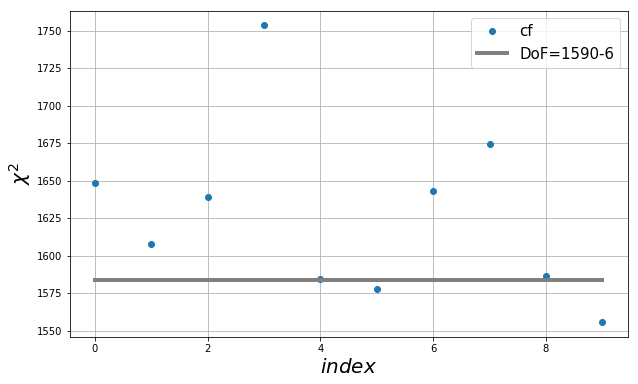

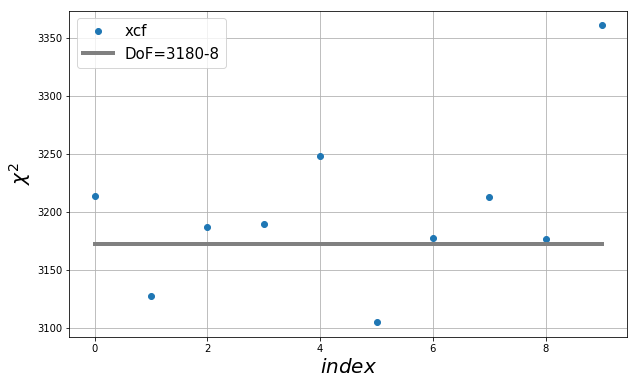

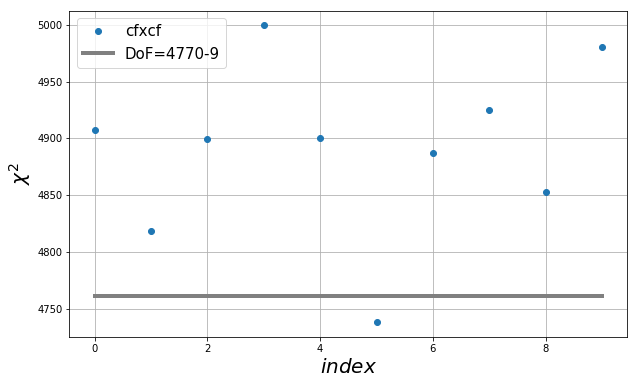

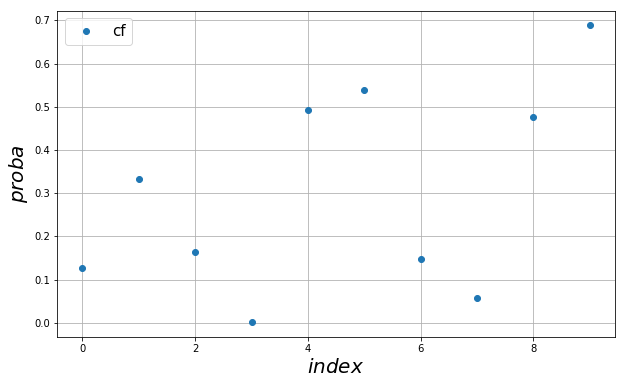

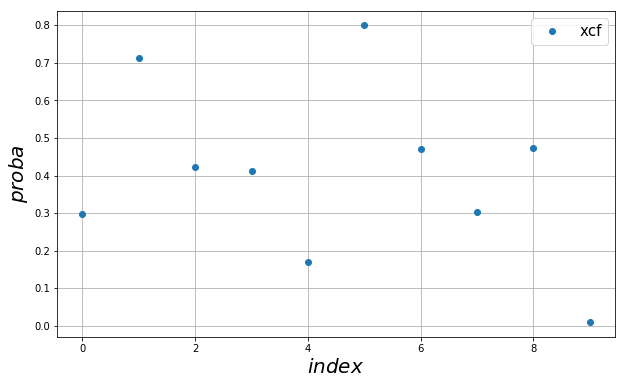

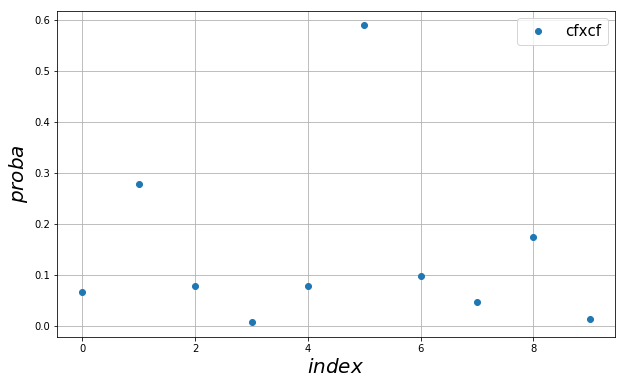

In [9]:
latexnameProba = {'fval':'\chi^{2}',
             'proba':'proba',}
for p in latexnameProba.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]

        for cor in ['cf','xcf','cfxcf','allCombined']:
            
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            exp = sp.zeros(mock['nbReal'])
            ndata = sp.zeros(mock['nbReal'])
            npar = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p]
                    exp[idx] = toPlot[name]['FIT_RES']['ndata']-toPlot[name]['FIT_RES']['npar']
                    ndata[idx] = toPlot[name]['FIT_RES']['ndata']
                    npar[idx] = toPlot[name]['FIT_RES']['npar']
            w = exp>0.
            if w.sum()==0: continue
            plt.errorbar(xxx[w],yyy[w],fmt='o',label=cor)
            if p=='fval':
                if (exp[w]==exp[w][0]).sum()!=exp[w].size:
                    print(exp[w])
                plt.errorbar(xxx[w],exp[w],linewidth=4,color='grey',label='DoF={}-{}'.format(int(ndata[w][0]),int(npar[w][0])))

            plt.xlabel(r'$index$')
            plt.ylabel(r'$'+latexnameProba[p]+'$')
            plt.legend(fontsize=15)
            plt.grid()
            plt.show()

### Histogram of Chi2 and probability

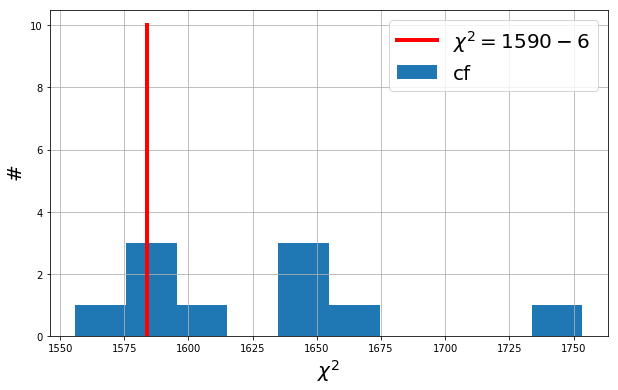

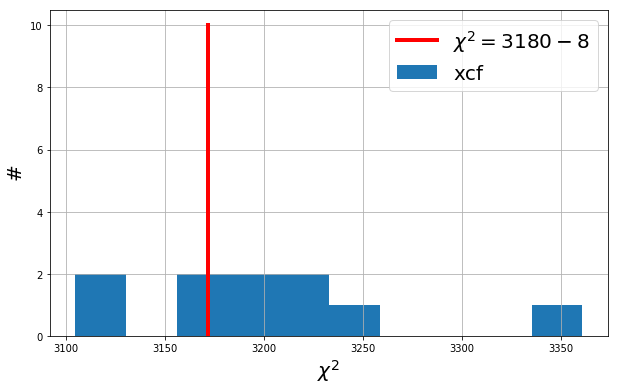

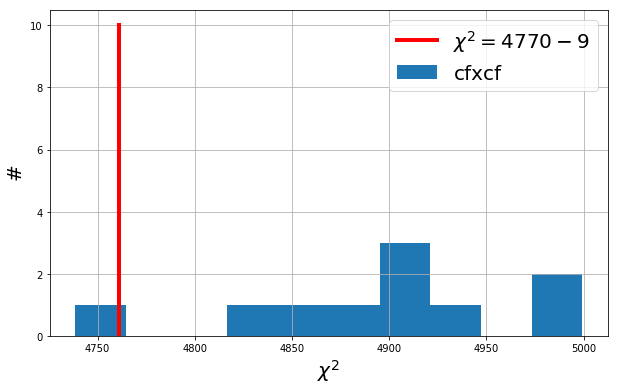

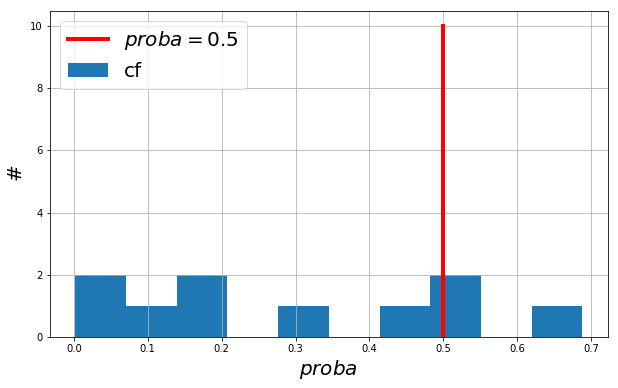

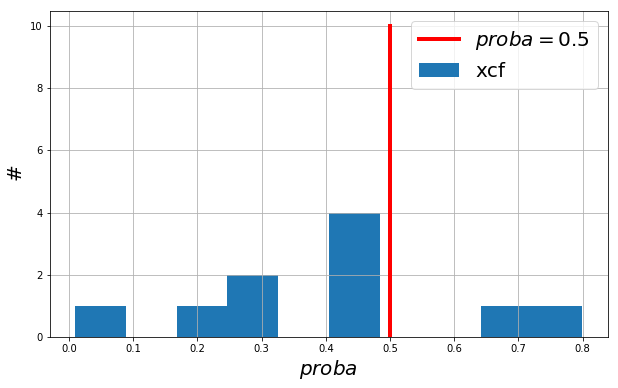

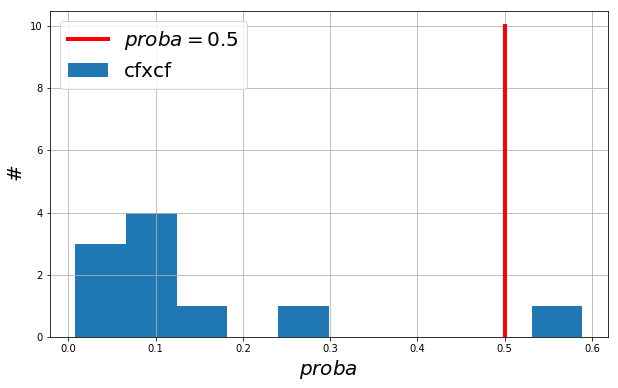

In [10]:
latexnameProba = {'fval':'\chi^{2}',
                'proba':'proba',}
for p in latexnameProba.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]

        for cor in ['cf','xcf','cfxcf','allCombined']:
            
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            exp = sp.zeros(mock['nbReal'])
            ndata = sp.zeros(mock['nbReal'])
            npar = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p]
                    exp[idx] = toPlot[name]['FIT_RES']['ndata']-toPlot[name]['FIT_RES']['npar']
                    ndata[idx] = toPlot[name]['FIT_RES']['ndata']
                    npar[idx] = toPlot[name]['FIT_RES']['npar']
            w = exp>0.
            if w.sum()==0: continue
            plt.hist(yyy[w],bins=10,label=cor)
            if p=='fval':
                plt.plot([exp[0],exp[0]],[0.,10.],color='red',label=r'$\chi^{2}='+str(int(ndata[0]))+'-'+str(int(npar[0]))+'$')
            elif p=='proba':
                plt.plot([0.5,0.5],[0.,10.],color='red',label=r'$proba={}$'.format(0.5))
            plt.xlabel(r'$'+latexnameProba[p]+'$')
            plt.ylabel(r'$\#$')
            plt.legend()
            plt.grid()
            plt.show()

### Parameters

In [11]:
omega_M_0 = 0.3147
def alpha(z,a0,a1,zeff=2.30):
    evol = a0*((1.+z)/(1.+zeff))**a1
    return evol
def bias_vs_z_std(z, zref, alpha):
    r = ((1.+z)/(1+zref))**alpha
    return r
def growthRateStructure(z, omega_M_0=0.3147):
    omega_m = omega_M_0*(1.+z)**3 / ( omega_M_0*(1.+z)**3+(1.-omega_M_0))
    f = sp.power(omega_m,0.55)
    return f

In [12]:
biasCoLoRe = sp.loadtxt(os.path.expandvars(mock['input_bias_QSO_evol']))
betaCoLoRe = growthRateStructure(biasCoLoRe[:,0], omega_M_0)/biasCoLoRe[:,1]
fromztobiasQso = interp1d(biasCoLoRe[:,0],betaCoLoRe)
print(toPlot['0-Mock-xcf-z-0-10']['FIT_RES']['ZEFF'], fromztobiasQso(toPlot['0-Mock-xcf-z-0-10']['FIT_RES']['ZEFF']))

2.3 0.25927070812764497


In [13]:
latexname = {'ap':'\\alpha_{\parallel}',
             'at':'\\alpha_{\perp}',
             'bias_eta_LYA' : 'b_{\\eta,\mathrm{Ly}\\alpha}',
             'beta_LYA' : '\\beta_{\mathrm{Ly}\\alpha}',
             'beta_QSO' : '\\beta_{\mathrm{qso}}',
             'sigma_velo_lorentz_QSO':'\sigma_{v}\,[\mathrm{h^{-1}\,Mpc}]',
             'drp_QSO':'\Delta r_{\parallel}\,[\mathrm{h^{-1}\,Mpc}]',
             #'par binsize cf_z_0_10-exp': 'R_{\\parallel}',
             #'per binsize cf_z_0_10-exp': 'R_{\\perp}',
             #'par binsize xcf_z_0_10-exp': 'R_{\\parallel}',
             #'per binsize xcf_z_0_10-exp': 'R_{\\perp}',
             'par_sigma_smooth': 'par-sigma-smooth',
             'per_sigma_smooth': 'per-sigma-smooth',
            }
expected = {'ap':1.,
             'at':1.,
             'bias_eta_LYA' : None,
             'beta_LYA' : None,
             'beta_QSO' : fromztobiasQso(toPlot['0-Mock-xcf-z-0-10']['FIT_RES']['ZEFF']),
             'sigma_velo_lorentz_QSO':None,
             'drp_QSO':0.,
             #'par binsize cf_z_0_10-exp': None,
             #'per binsize cf_z_0_10-exp': None,
             #'par binsize xcf_z_0_10-exp': None,
             #'per binsize xcf_z_0_10-exp': None,
             'par_sigma_smooth': None,
             'per_sigma_smooth': None,
            }
expected_error = {}
expected_error['cf'] = {'ap':0.031,'at':0.042, 'bias_eta_LYA':0.004, 'beta_LYA':0.101}
expected_error['xcf'] = {'ap':0.039,'at':0.042}
expected_error['cfxcf'] = {'ap':0.025,'at':0.030, 'bias_eta_LYA':0.004, 'beta_LYA':0.099, 'beta_QSO': 0.006}

# __BAO summary table__

In [14]:
def get_precision(error,nb_diggit=2):

    precision = int( nb_diggit -1 -sp.floor( sp.log10(error) ) )

    return precision
def precision_and_scale(x):

    '''
    http://stackoverflow.com/questions/3018758/determine-precision-and-scale-of-particular-number-in-python
    '''

    max_digits = 14
    int_part = int(abs(x))
    magnitude = 1 if int_part == 0 else int(sp.log10(int_part)) + 1
    if magnitude >= max_digits:
        return (magnitude, 0)

    frac_part = abs(x) - int_part
    multiplier = 10 ** (max_digits - magnitude)
    frac_digits = multiplier + int(multiplier * frac_part + 0.5)
    while frac_digits % 10 == 0:
        frac_digits /= 10
    scale = int(sp.log10(frac_digits))

    return (magnitude + scale, scale)
def format_number_with_precision(number,error,number_of_digit=2):

    precision = get_precision(error,number_of_digit)

    string = round(number,precision)
    digit  = precision_and_scale(string)
    string = str(string).ljust(digit[0]-digit[1]+1+precision,'0')

    return string
def dist_lines_Obs(lObs1,lObs2,lRF):

    z1 = lObs1/lRF-1.
    z2 = lObs2/lRF-1.
    z  = (z1+z2)/2.
    dz = z1-z2

    c = scipy.constants.speed_of_light/1000.
    hz = 100*sp.sqrt( constants.omegaM0*(1.+z)**3 + (1.-constants.omegaM0) )
    deltaRP = c*dz/hz

    return deltaRP

In [15]:
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    for cor in ['cf','xcf','cfxcf','allCombined']:
        
        to_print = ' || {} || '.format(cor)
        
        for p in ['ap','at','fval']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    if p=='fval':
                        yyy[idx] = toPlot[name]['FIT_RES'][p]
                        yer[idx] = 0.01
                    else:
                        yyy[idx] = toPlot[name]['FIT_RES'][p][0]
                        yer[idx] = toPlot[name]['FIT_RES'][p][1]
            w = yer>0.
            if w.sum()==0: continue
            mean = yyy[w].mean()
            err = yyy[w].std()/sp.sqrt(yyy[w].size)
            meanErr = yer[w].mean()
            meanErrCombined = meanErr/sp.sqrt(yyy[w].size)
            if p=='fval':
                to_print += ' {} || '.format(format_number_with_precision(yyy[w].sum(),meanErr))
            else:
                to_print += ' {} +/- {} || '.format(format_number_with_precision(mean,meanErr), format_number_with_precision(meanErr,meanErr))
        print(to_print)

for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    for cor in ['cf','xcf','cfxcf','allCombined']:
        
        to_print = ' || {} || '.format(cor)
        
        for p in ['ap','at','fval']:
            xxx = 1.*sp.arange(1)
            yyy = sp.zeros(1)
            yer = sp.zeros(1)
            name = '{}-Mock-{}-z-{}-{}'.format('all',cor,zmin,zmax)
            if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                if p=='fval':
                    yyy[0] = toPlot[name]['FIT_RES'][p]
                    yer[0] = 0.01
                else:
                    yyy[0] = toPlot[name]['FIT_RES'][p][0]
                    yer[0] = toPlot[name]['FIT_RES'][p][1]
            w = yer>0.
            if w.sum()==0: continue
            mean = yyy[w].mean()
            meanErr = yer[w].mean()
            if p=='fval':
                to_print += ' {} || '.format(format_number_with_precision(mean,meanErr))
            else:
                to_print += ' {} +/- {} || '.format(format_number_with_precision(mean,meanErr), format_number_with_precision(meanErr,meanErr))
        print(to_print)

 || cf ||  1.017 +/- 0.036 ||  1.005 +/- 0.049 ||  16271.371 || 
 || xcf ||  1.026 +/- 0.042 ||  0.980 +/- 0.034 ||  31996.800 || 
 || cfxcf ||  1.021 +/- 0.028 ||  0.990 +/- 0.028 ||  48909.435 || 
 || allCombined || 
 || cf ||  1.017 +/- 0.012 ||  0.991 +/- 0.015 ||  1858.789 || 
 || xcf ||  1.020 +/- 0.014 ||  0.985 +/- 0.012 ||  3407.320 || 
 || cfxcf ||  1.0191 +/- 0.0093 ||  0.9872 +/- 0.0092 ||  5795.369 || 
 || allCombined || 


### The parameters as a function of mock index

cf: <ap> = 1.017358778342416 +/- 0.006928920171582343 (<0.03554702638015873>, 0.0112409567407392)
xcf: <ap> = 1.025722399454628 +/- 0.010747621000918684 (<0.04207877720502456>, 0.013306477712265159)
cfxcf: <ap> = 1.0207642835306758 +/- 0.003943512788062924 (<0.027702020265239373>, 0.008760147982629819)


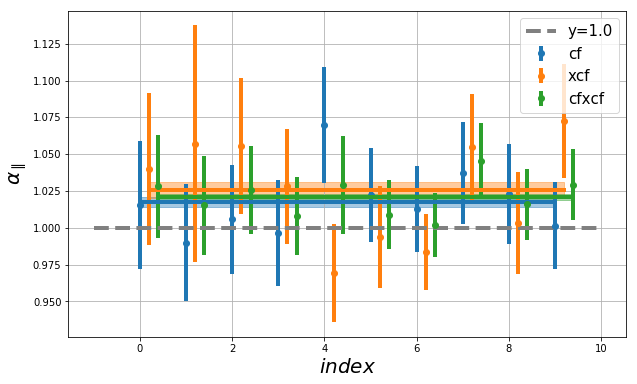

cf: <at> = 1.004623599510946 +/- 0.016261941660834733 (<0.04896136632095034>, 0.015482943492806173)
xcf: <at> = 0.98015430953252 +/- 0.010343043036117704 (<0.03417924534620933>, 0.010808426399973179)
cfxcf: <at> = 0.9900878397749958 +/- 0.009621431069127148 (<0.028417713355827524>, 0.008986470009820197)


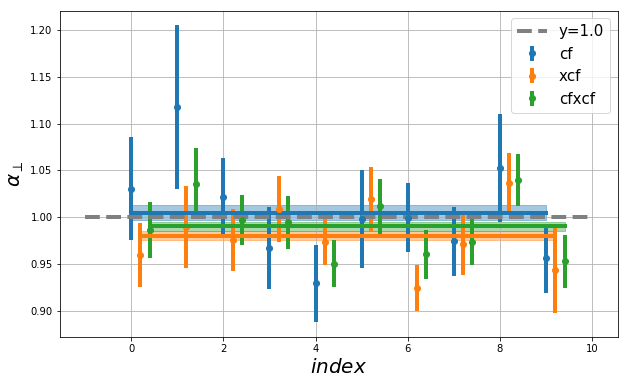

cf: <bias_eta_LYA> = -0.1512001419343064 +/- 0.0010585902977003456 (<0.0030105855699665844>, 0.0009520307491930616)
xcf: <bias_eta_LYA> = -0.1411614867408985 +/- 0.001667151101796924 (<0.004778814844298995>, 0.001511193942420774)
cfxcf: <bias_eta_LYA> = -0.14730133175885393 +/- 0.0008293886865812679 (<0.002543239787212699>, 0.0008042430363554101)


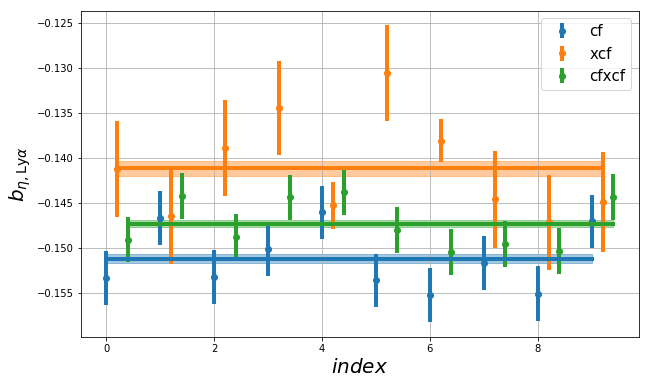

cf: <beta_LYA> = 1.1293095720024495 +/- 0.01245337113439649 (<0.036851721201828266>, 0.011653537469529494)
xcf: <beta_LYA> = 1.0737521481097834 +/- 0.018205347110403152 (<0.0535298013954956>, 0.016927609510622586)
cfxcf: <beta_LYA> = 1.0975218966525175 +/- 0.009762464252929091 (<0.030399781179030534>, 0.009613254889645541)


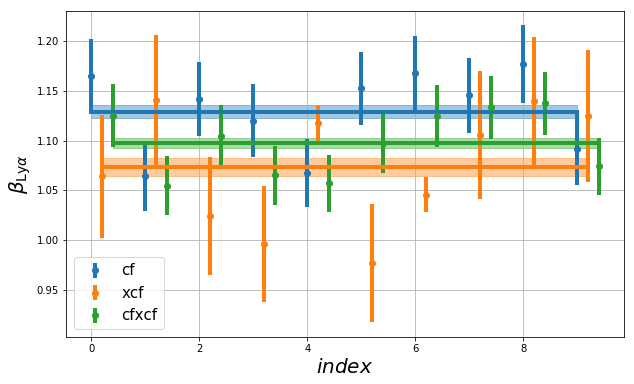

cfxcf: <beta_QSO> = 0.2488009937676075 +/- 0.0008969755987154407 (<0.0026466595263891193>, 0.0008369472294372135)


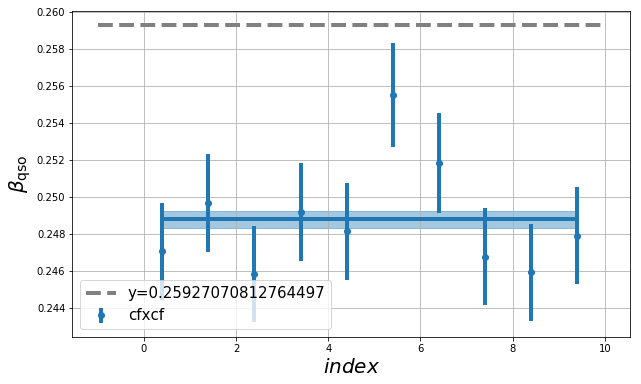

xcf: <sigma_velo_lorentz_QSO> = -0.1803981655276122 +/- 0.1312856046648446 (<15.585078530419201>, 4.928434566871447)
cfxcf: <sigma_velo_lorentz_QSO> = 0.00011081395761305119 +/- 0.00019324870880332179 (<0.2580257324440033>, 0.08159490094562549)


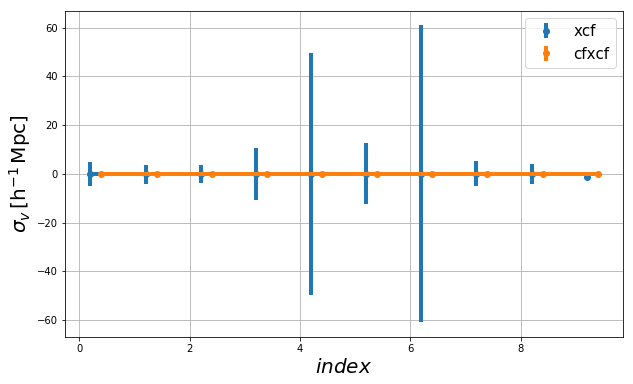

xcf: <drp_QSO> = 0.19205829014912593 +/- 0.018569454272686147 (<0.07503444955581513>, 0.023727976357338535)
cfxcf: <drp_QSO> = 0.18769548974540945 +/- 0.01701789569818038 (<0.07582792080577926>, 0.023978893998113277)


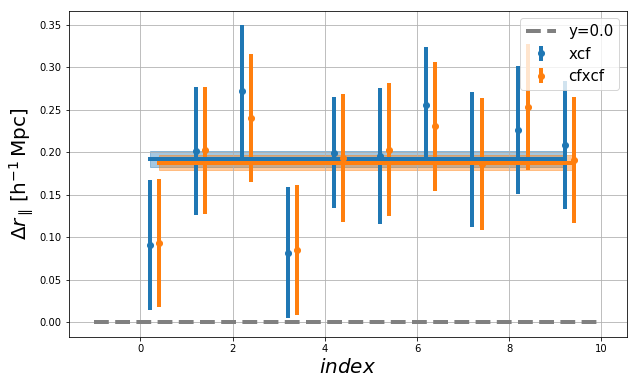

cf: <par_sigma_smooth> = 3.211443748742849 +/- 0.027054404725056467 (<0.1166268199171139>, 0.03688063872003699)
xcf: <par_sigma_smooth> = 0.48602170292772573 +/- 0.361112231871061 (<1.2717610699016066>, 0.4021661620421687)
cfxcf: <par_sigma_smooth> = 2.65324818575315 +/- 0.03130360929463614 (<0.10697309798614958>, 0.033827863800060386)


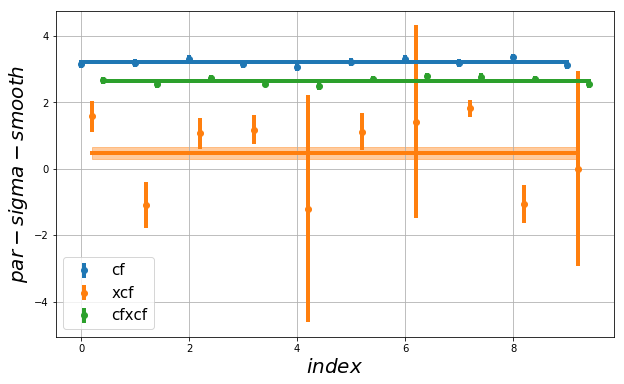

cf: <per_sigma_smooth> = 3.600258126384528 +/- 0.038450563154195753 (<0.18951491928253064>, 0.059929879551576026)
xcf: <per_sigma_smooth> = 3.2774399455692516 +/- 0.0471900121165867 (<0.21174754311652194>, 0.0669604525192918)
cfxcf: <per_sigma_smooth> = 3.563925750490919 +/- 0.036131262563318826 (<0.13176831893230595>, 0.04166880112775732)


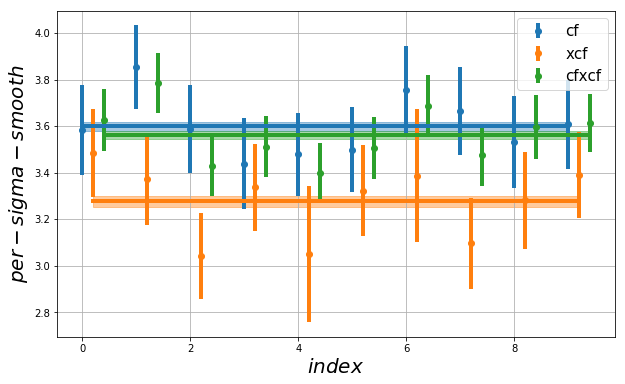

In [16]:
for p in latexname.keys():
    if not expected[p] is None:
        plt.plot(sp.arange(mock['nbReal']+2)-1.,expected[p]*sp.ones(mock['nbReal']+2),
                 '--',linewidth=4,color='grey',label='y={}'.format(expected[p]))
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf','allCombined']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p][0]
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf': xxx += 0.2
            if cor=='cfxcf': xxx += 0.4
            if p=='sigma_velo_lorentz': yyy = sp.absolute(yyy)
            w = yer>0.
            if w.sum()==0: continue
            item = plt.errorbar(xxx[w],yyy[w],yerr=yer[w],fmt='o',label=cor)
            mean = yyy[w].mean()
            err = yyy[w].std()/sp.sqrt(yyy[w].size)
            meanErr = yer[w].mean()
            print('{}: <{}> = {} +/- {} (<{}>, {})'.format(cor, p,mean,err,meanErr,meanErr/sp.sqrt(yyy[w].size)))
            plt.errorbar(xxx,mean*sp.ones(xxx.size),color=item[0].get_color())
            plt.fill_between( xxx, mean*sp.ones(xxx.size)-err/2., mean*sp.ones(xxx.size)+err/2.,alpha=0.4,color=item[0].get_color())
    plt.xlabel(r'$index$')
    plt.ylabel(r'$'+latexname[p]+'$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### The error as a function of mock index

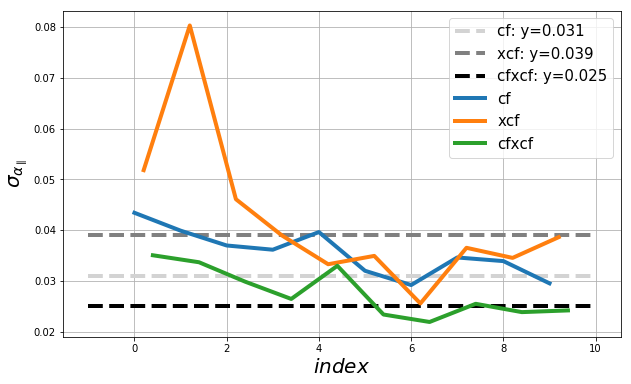

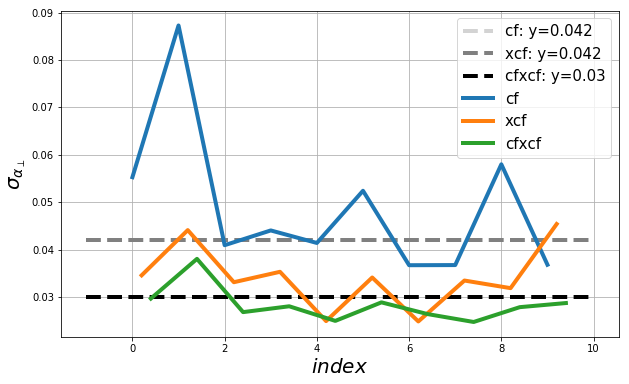

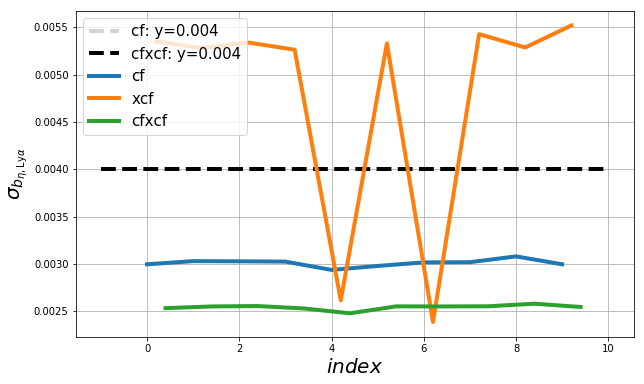

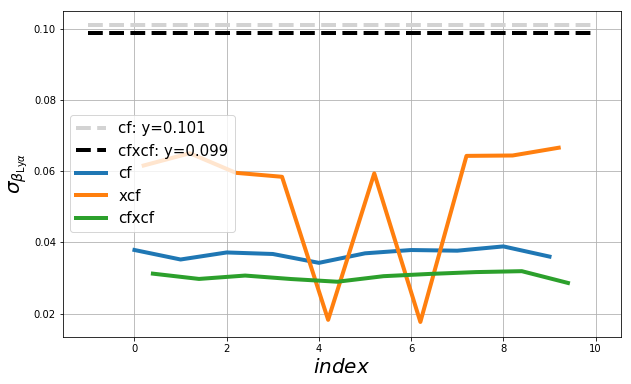

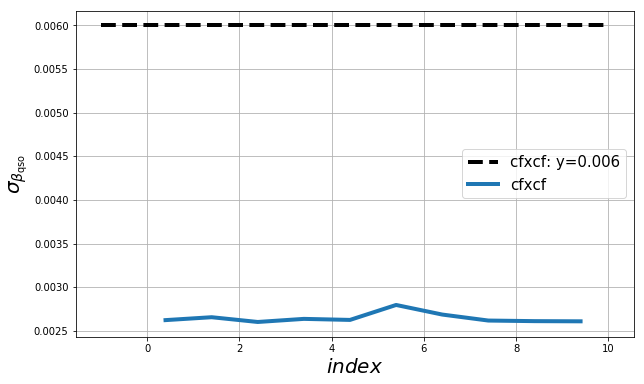

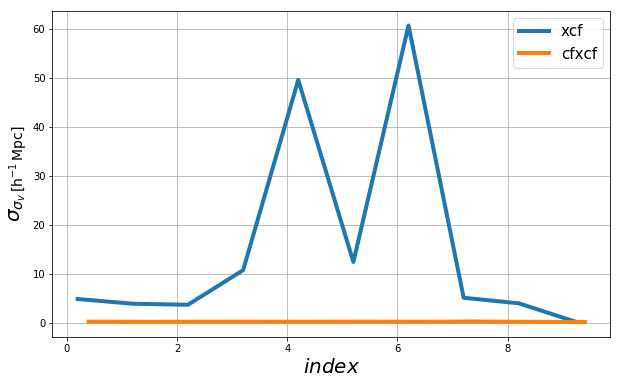

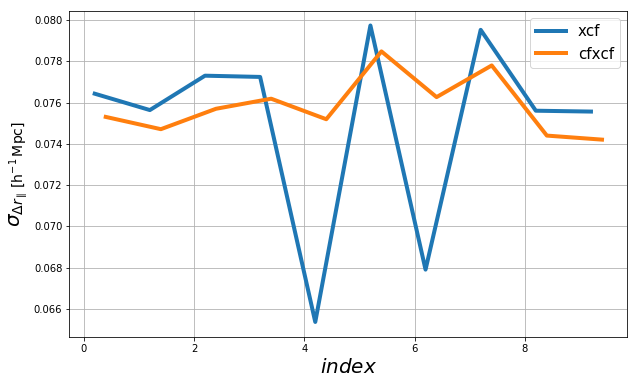

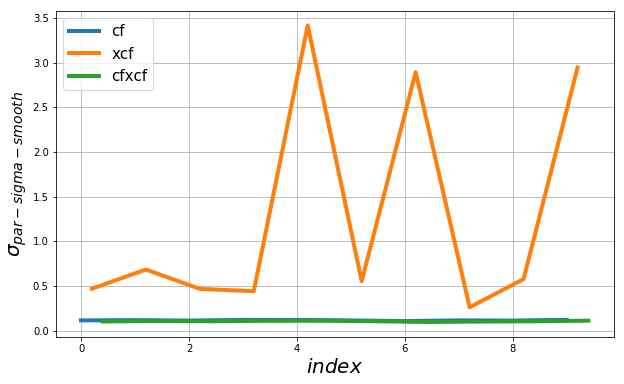

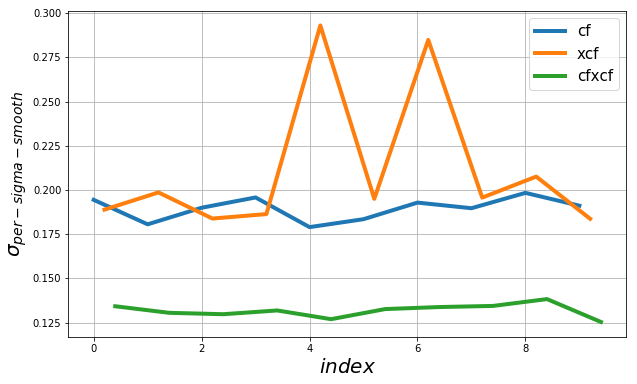

In [17]:
for p in latexname.keys():
    for i,cor in enumerate(expected_error.keys()):
        color = ['lightgrey','grey','black']
        if (p in expected_error[cor].keys()) and (not expected_error[cor][p] is None):
            plt.plot(sp.arange(mock['nbReal']+2)-1.,expected_error[cor][p]*sp.ones(mock['nbReal']+2),
                 '--',linewidth=4,color=color[i],label='{}: y={}'.format(cor, expected_error[cor][p]))
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf','allCombined']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf': xxx += 0.2
            if cor=='cfxcf': xxx += 0.4
            w = yer>0.
            if w.sum()==0: continue
            plt.errorbar(xxx[w],yer[w],label=cor)
    plt.xlabel(r'$index$')
    plt.ylabel(r'$\sigma_{'+latexname[p]+'}$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### The histograms of the parameters

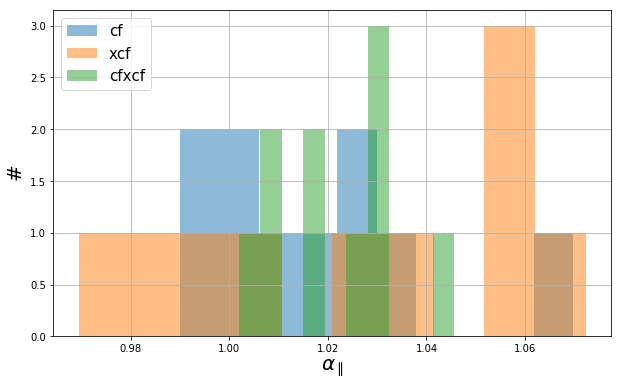

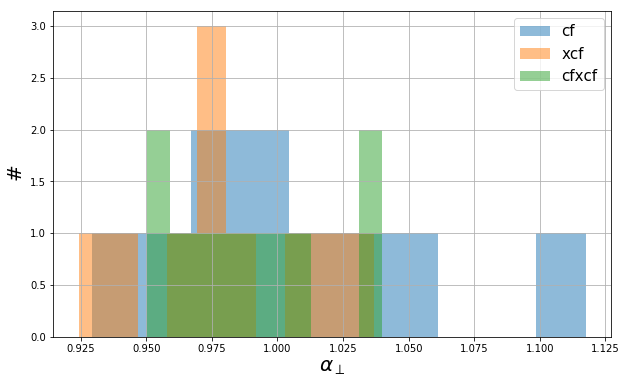

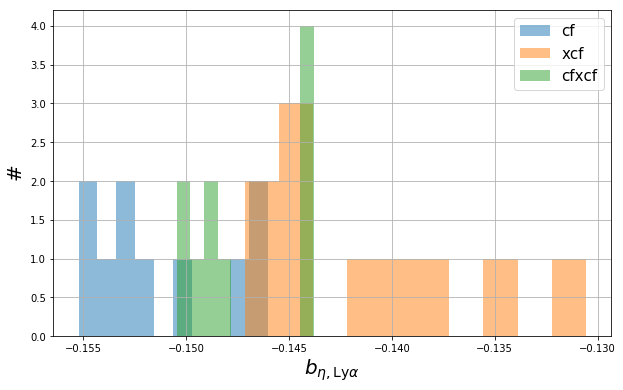

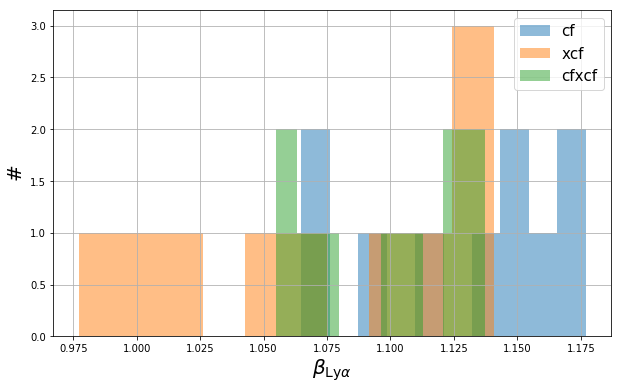

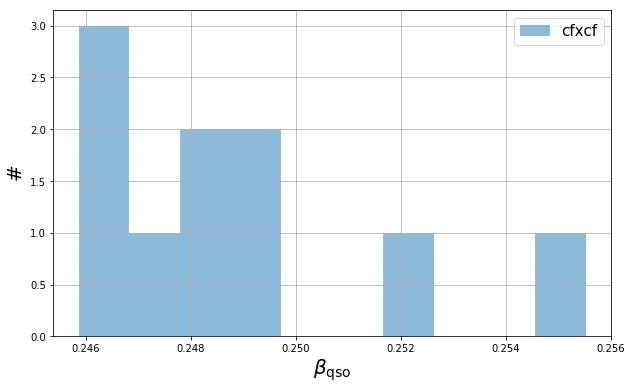

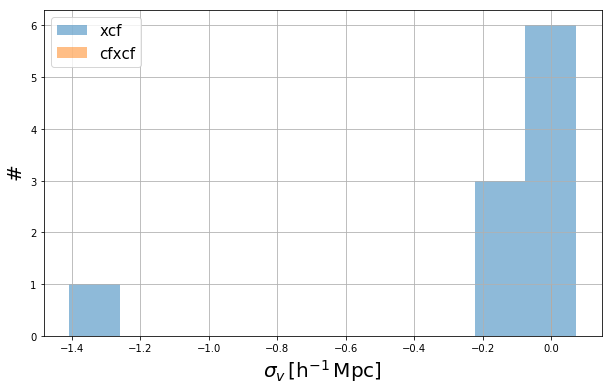

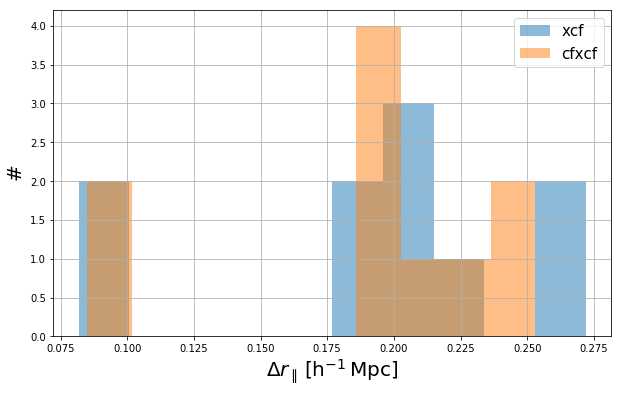

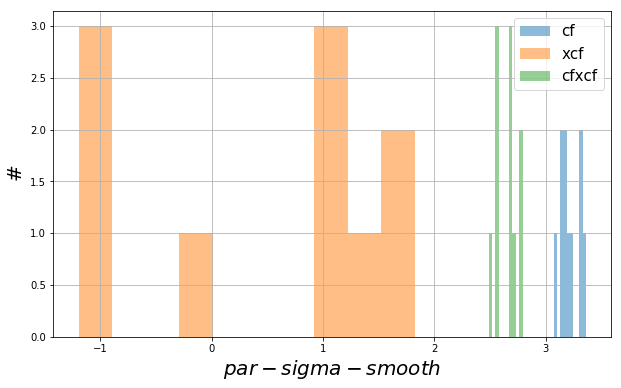

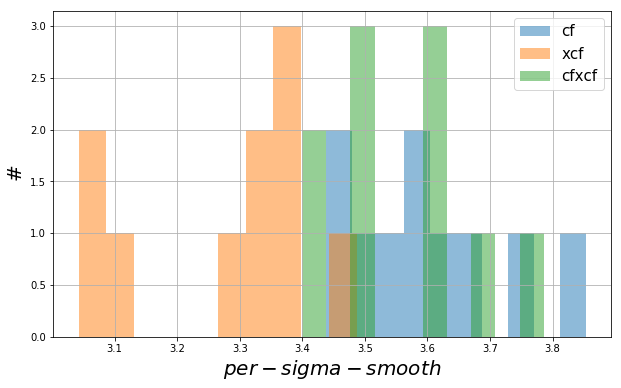

In [18]:
for p in latexname.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf','allCombined']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p][0]
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf':
                xxx += 0.3
            w = yer>0.
            if w.sum()==0: continue
            plt.hist(yyy[w],bins=10,alpha=0.5,label=cor)
            mean = yyy[w].mean()
            err = yyy[w].std()/sp.sqrt(yyy[w].size)
            meanErr = yer[w].mean()
    plt.xlabel(r'$'+latexname[p]+'$')
    plt.ylabel(r'$\#$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### Histogram of the errors

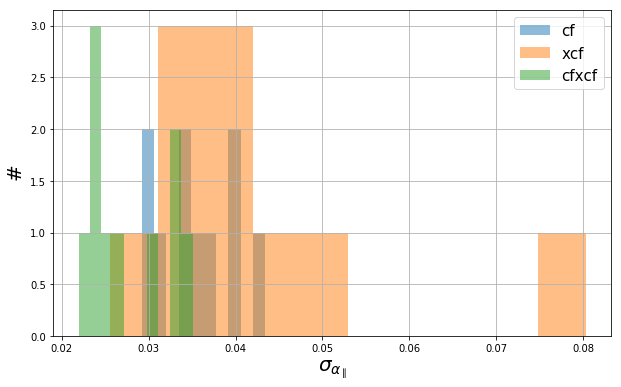

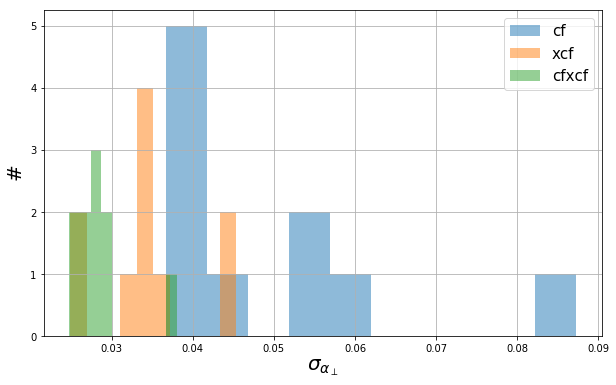

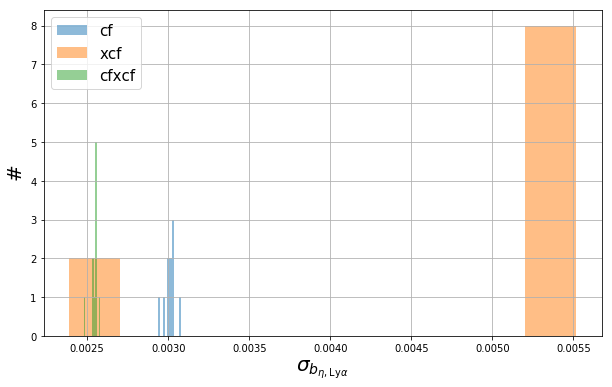

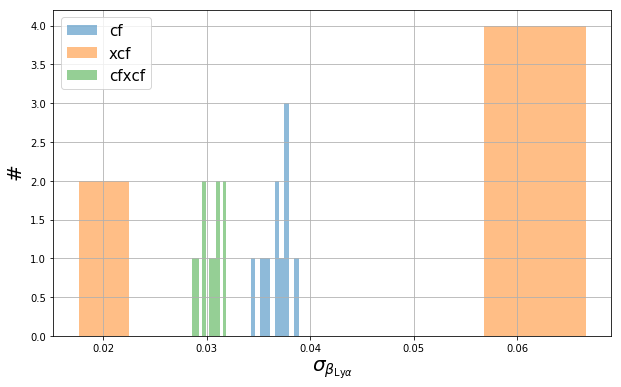

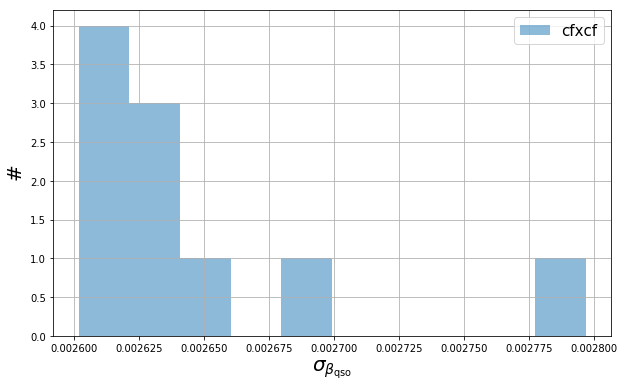

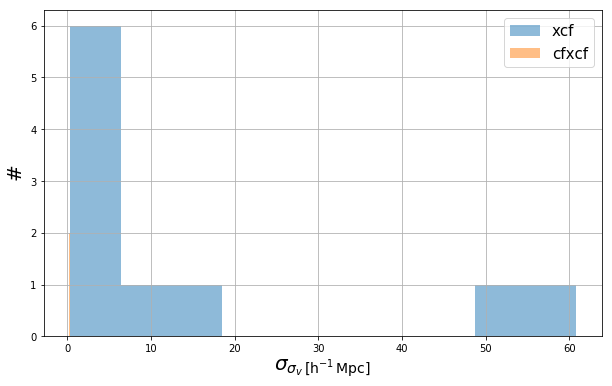

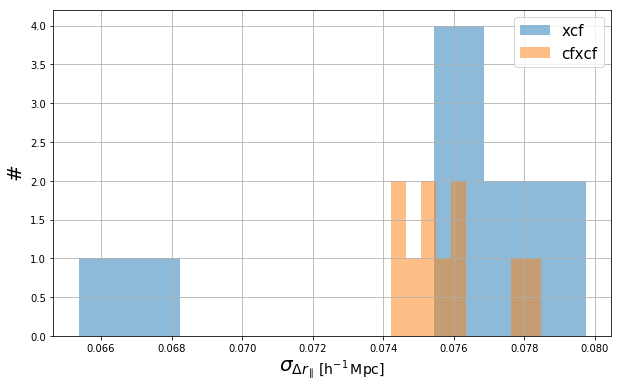

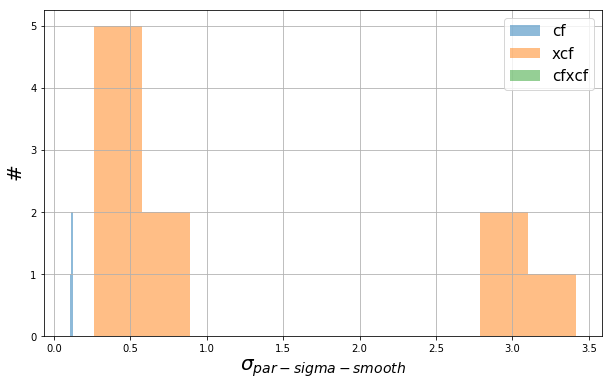

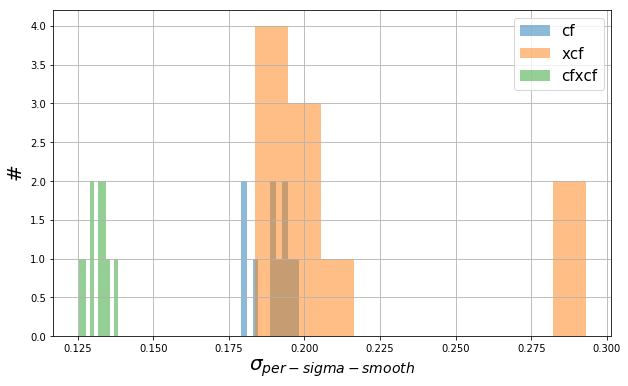

In [19]:
for p in latexname.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf','allCombined']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf':
                xxx += 0.3
            w = yer>0.
            if w.sum()==0: continue
            plt.hist(yer[w],bins=10,alpha=0.5,label=cor)
    plt.xlabel(r'$\sigma_{'+latexname[p]+'}$')
    plt.ylabel(r'$\#$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### The pull plots of the parameters

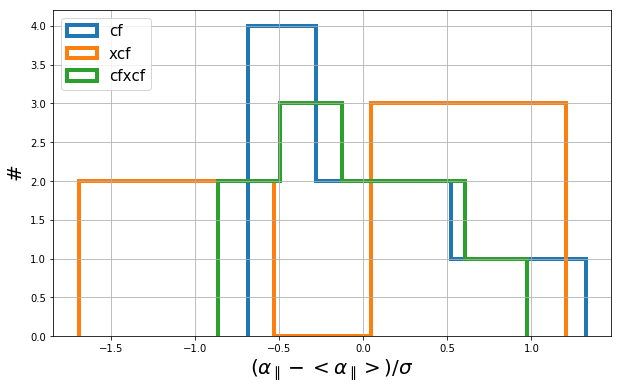

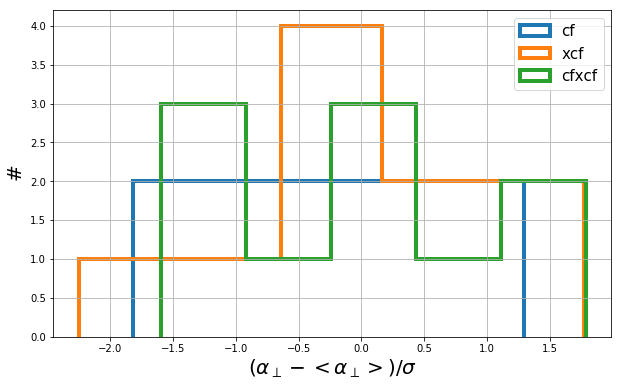

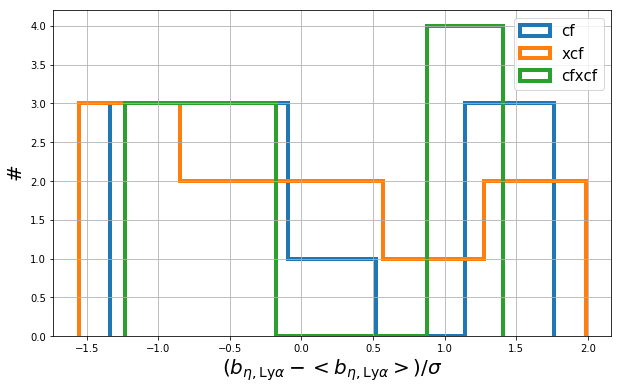

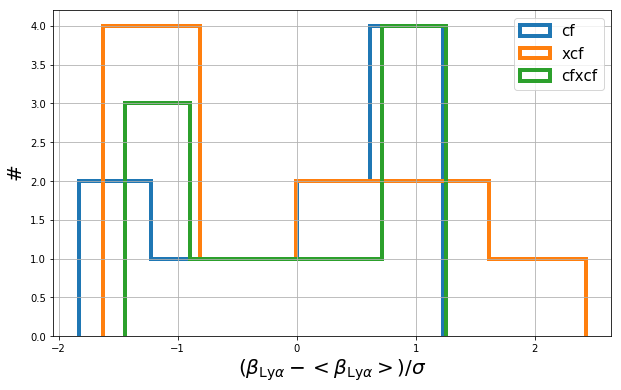

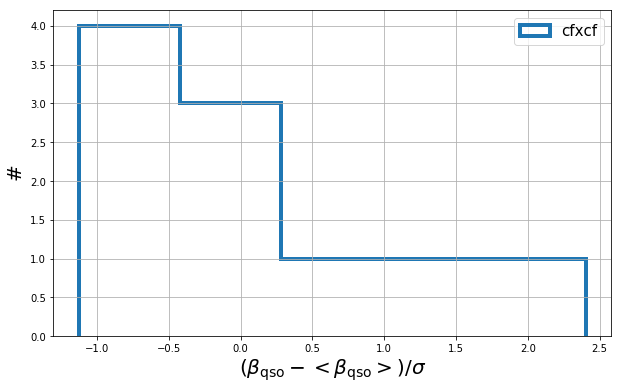

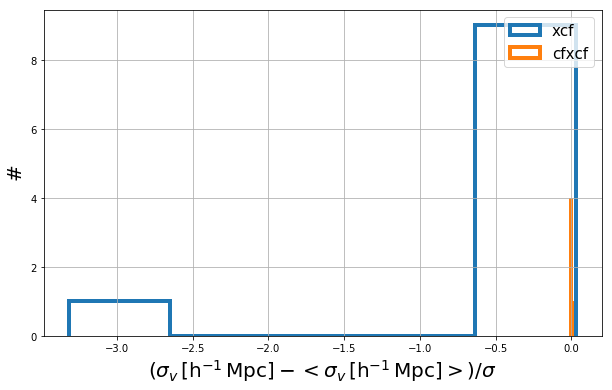

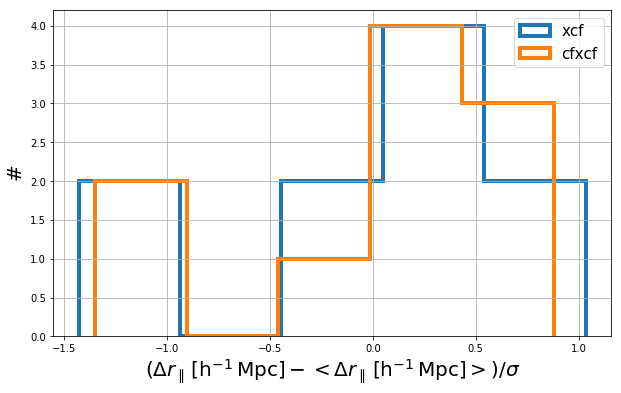

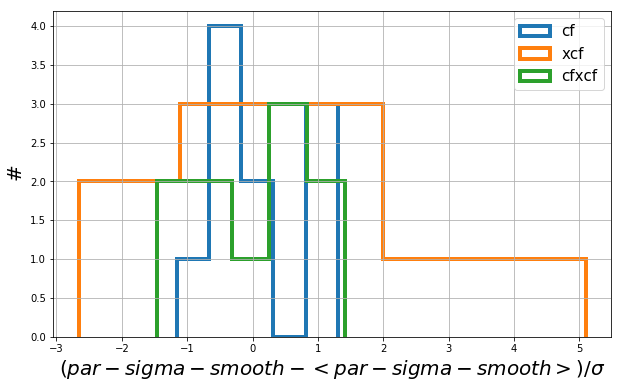

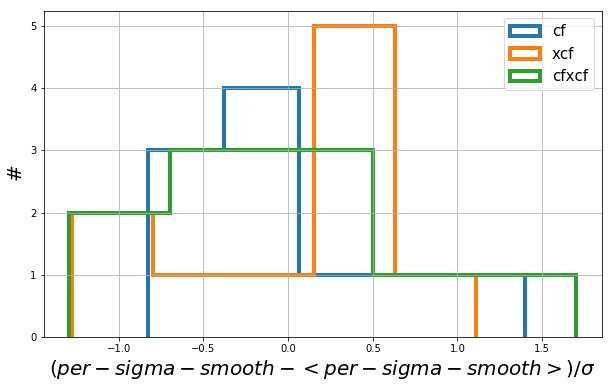

In [20]:
for p in latexname.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p][0]
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf':
                xxx += 0.3
            w = yer>0.
            if w.sum()==0: continue
            plt.hist( (yyy[w]-yyy[w].mean())/yer[w] ,bins=5,label=cor,histtype='step',linewidth=4)
    plt.xlabel(r'$('+latexname[p]+'-<'+latexname[p]+'>)/\sigma$')
    plt.ylabel(r'$\#$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### Correlation between different parameters

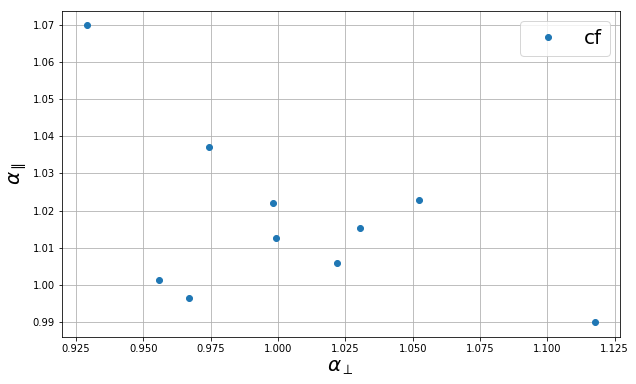

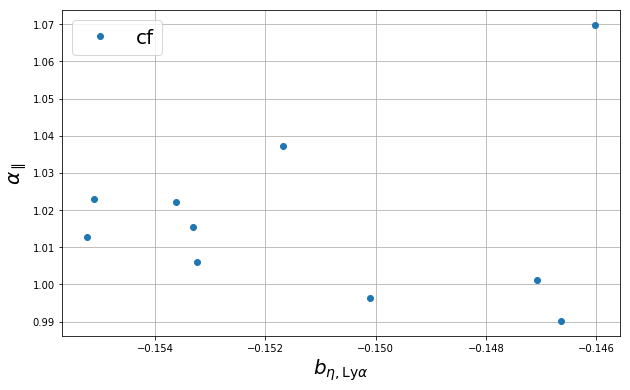

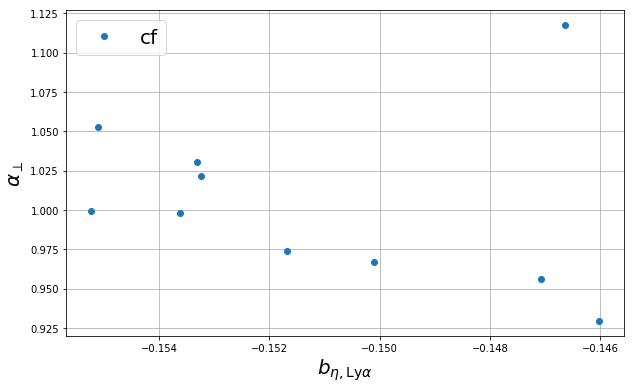

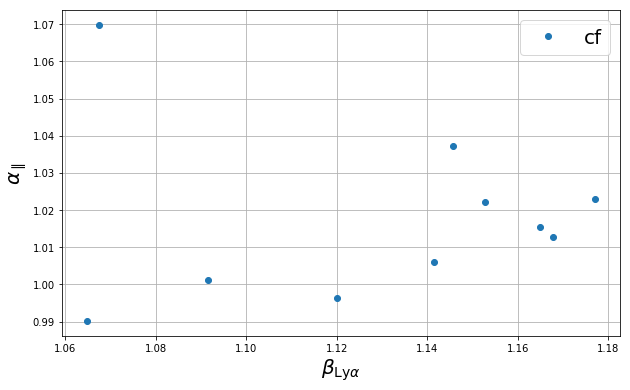

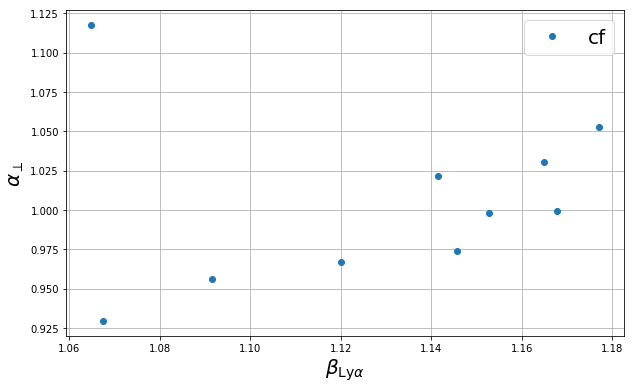

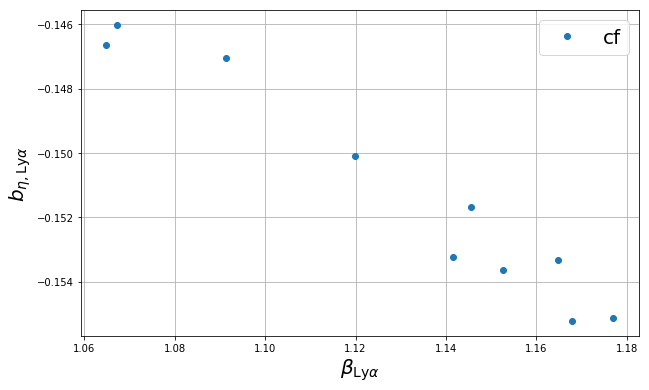

beta_QSO ap
beta_QSO at
beta_QSO bias_eta_LYA
beta_QSO beta_LYA
sigma_velo_lorentz_QSO ap
sigma_velo_lorentz_QSO at
sigma_velo_lorentz_QSO bias_eta_LYA
sigma_velo_lorentz_QSO beta_LYA
sigma_velo_lorentz_QSO beta_QSO
drp_QSO ap
drp_QSO at
drp_QSO bias_eta_LYA
drp_QSO beta_LYA
drp_QSO beta_QSO
drp_QSO sigma_velo_lorentz_QSO


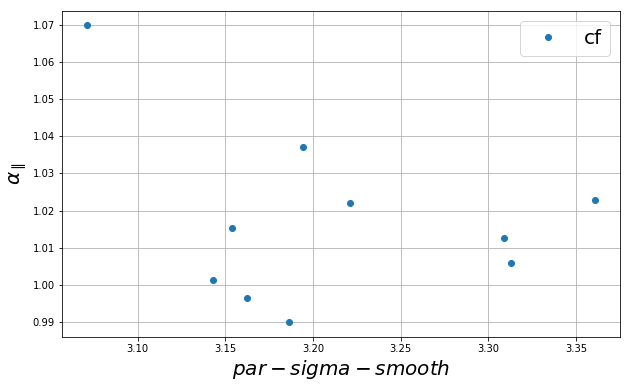

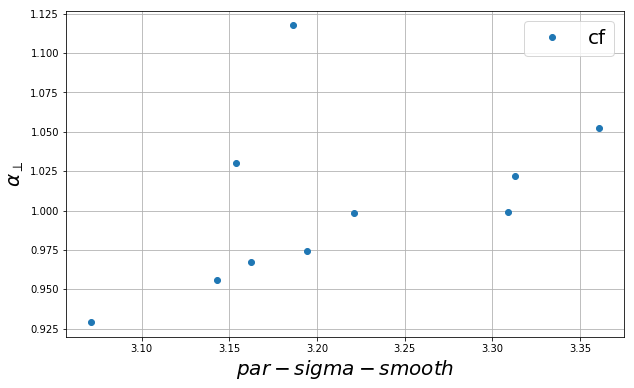

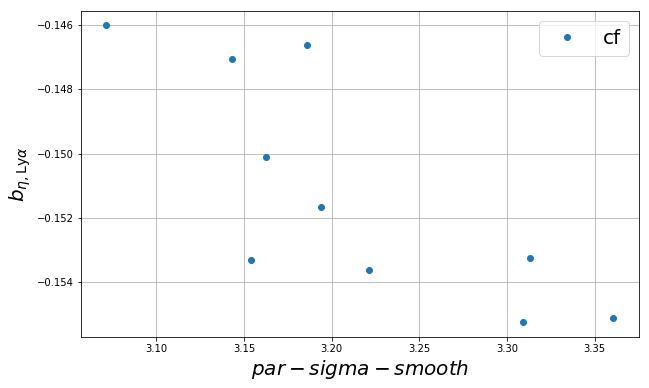

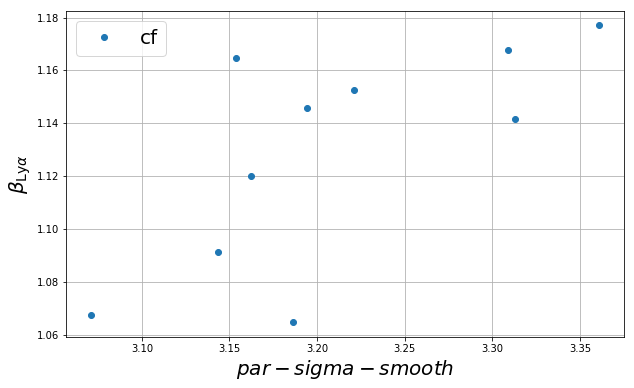

par_sigma_smooth beta_QSO
par_sigma_smooth sigma_velo_lorentz_QSO
par_sigma_smooth drp_QSO


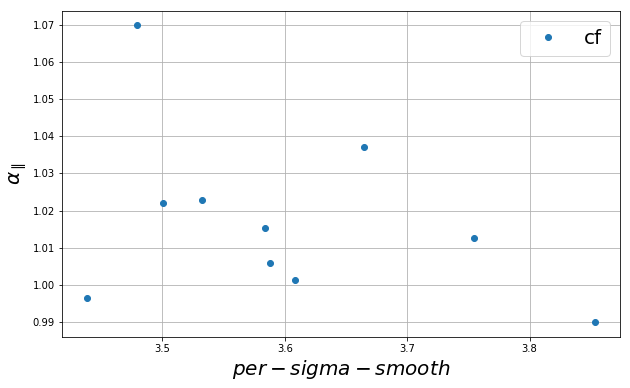

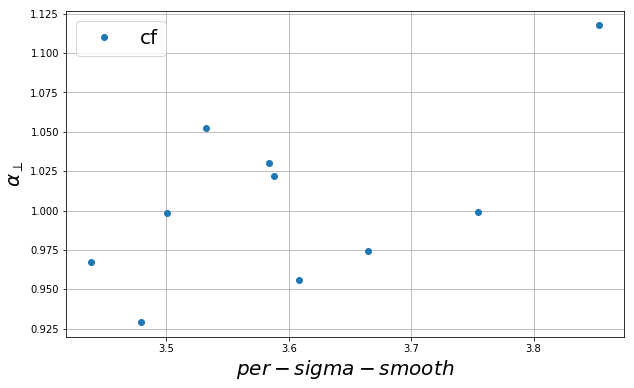

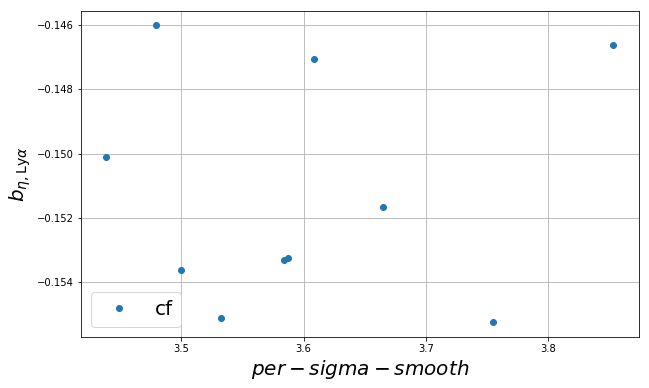

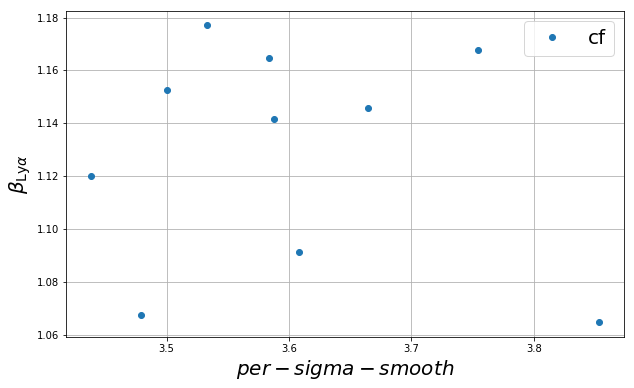

per_sigma_smooth beta_QSO
per_sigma_smooth sigma_velo_lorentz_QSO
per_sigma_smooth drp_QSO


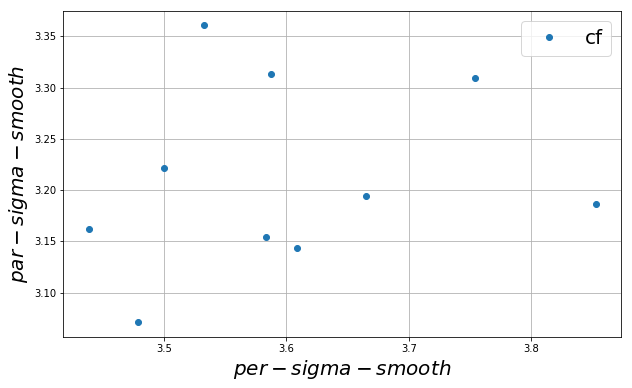

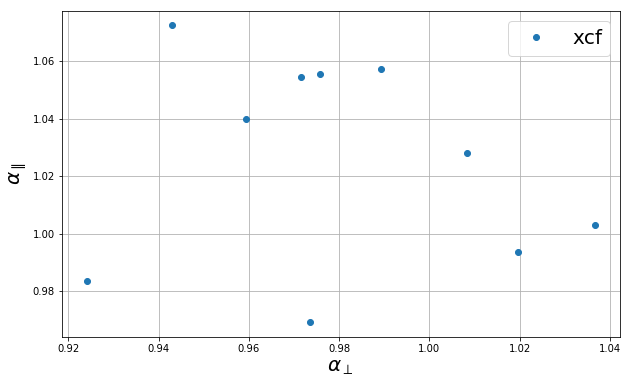

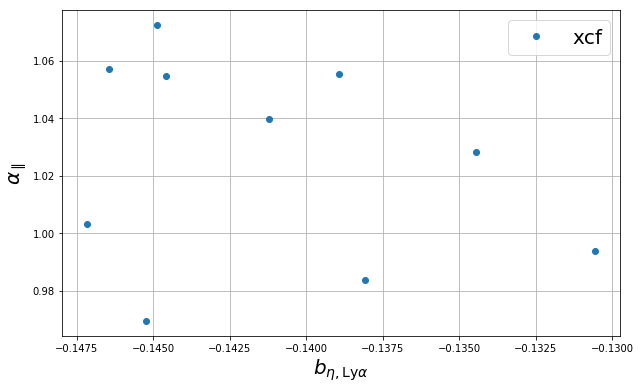

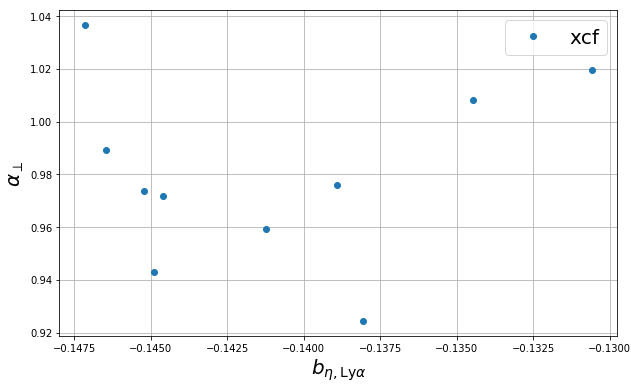

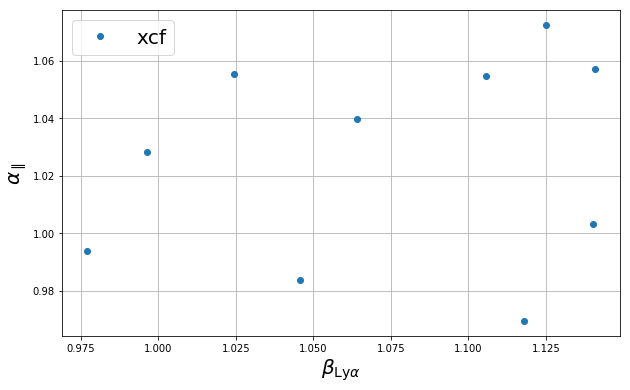

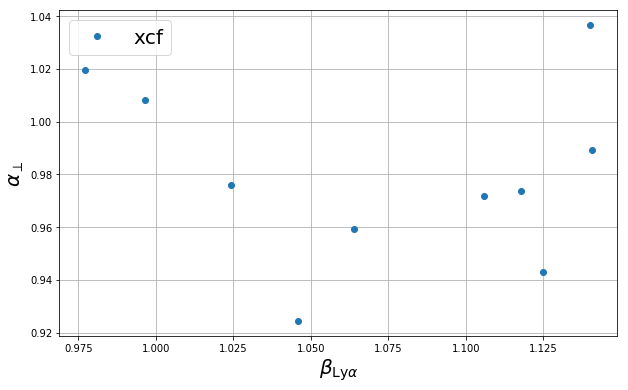

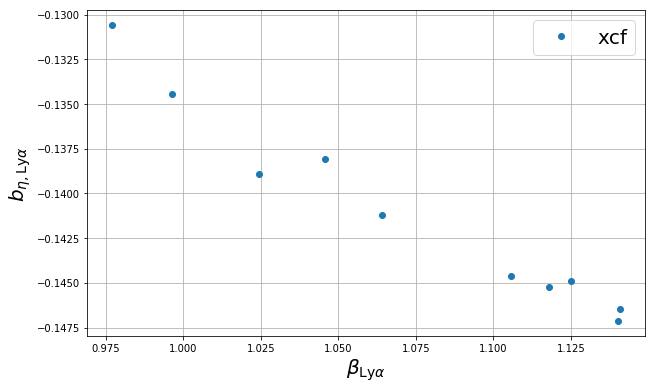

beta_QSO ap
beta_QSO at
beta_QSO bias_eta_LYA
beta_QSO beta_LYA


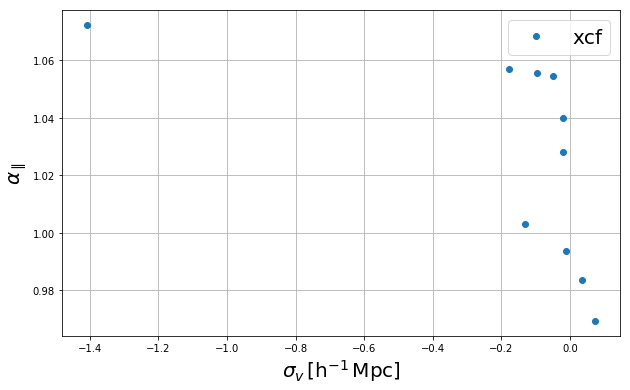

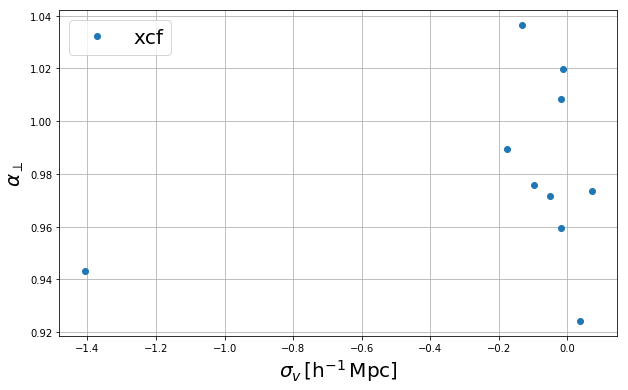

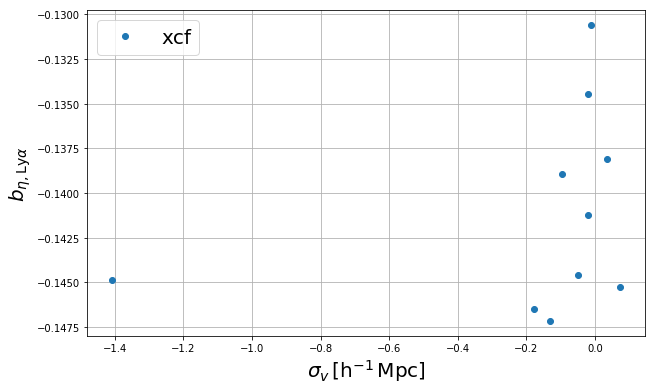

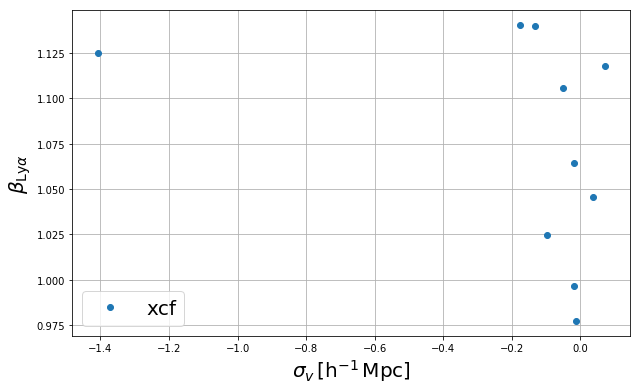

sigma_velo_lorentz_QSO beta_QSO


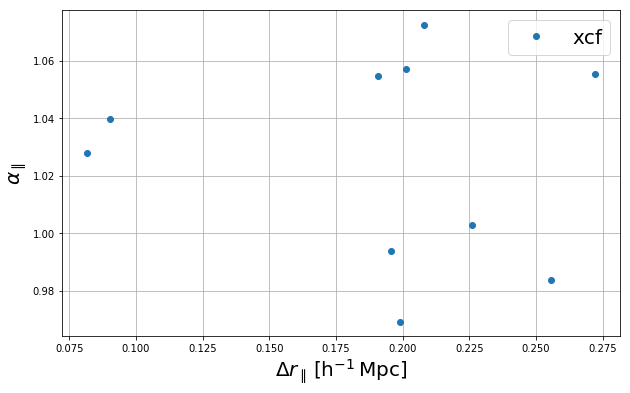

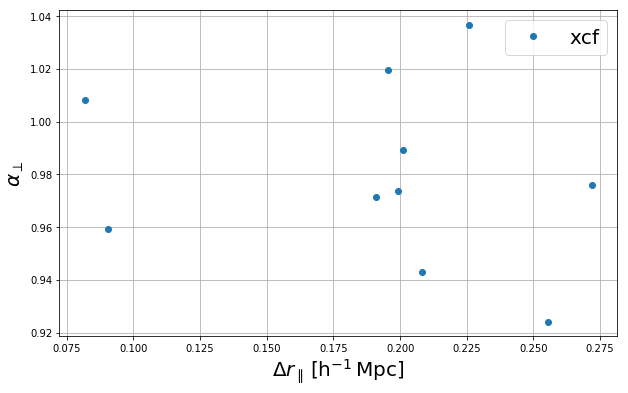

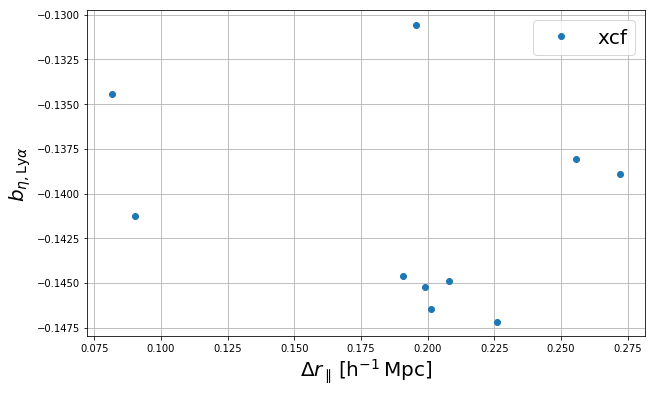

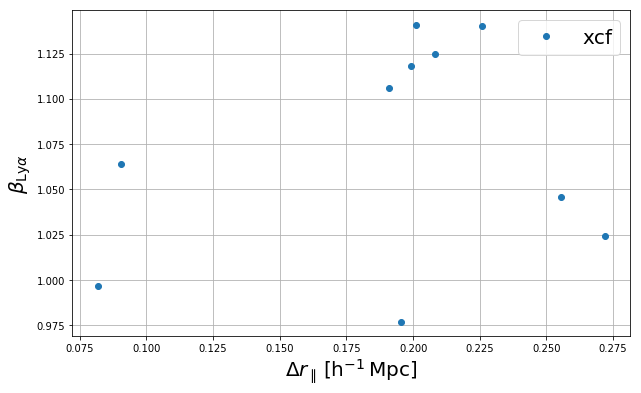

drp_QSO beta_QSO


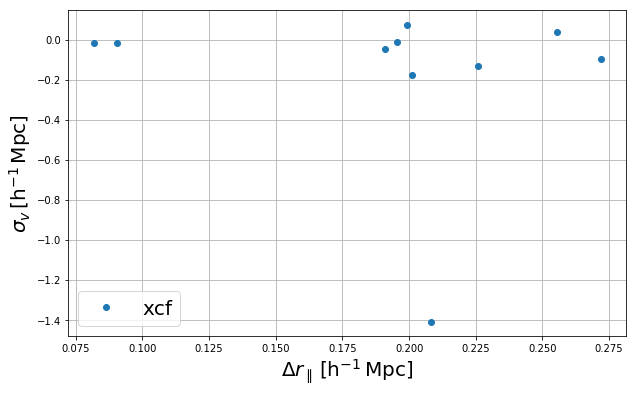

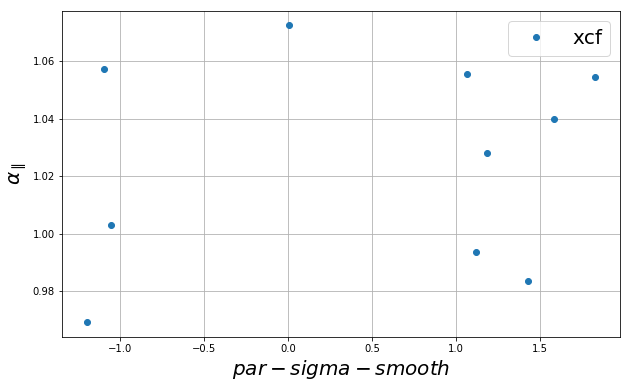

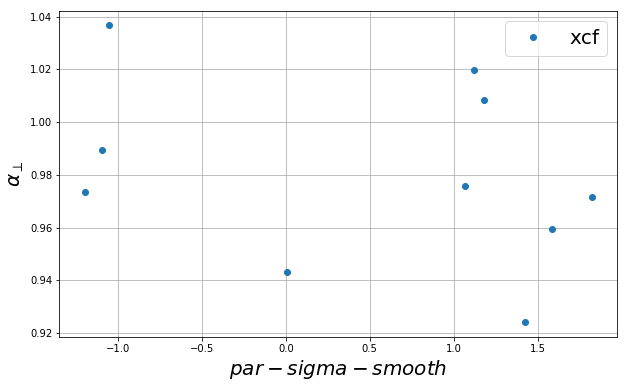

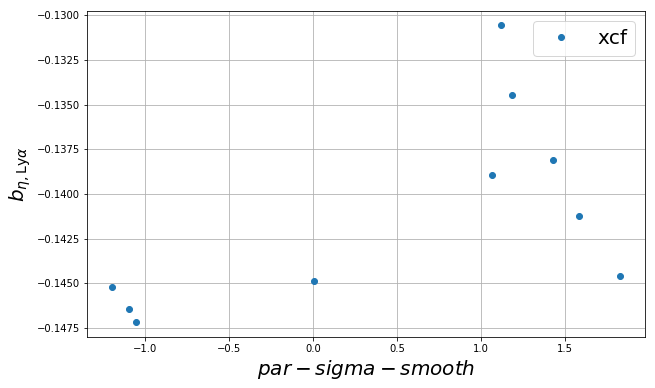

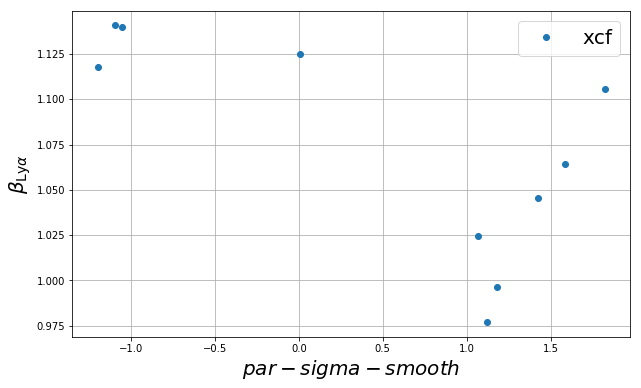

par_sigma_smooth beta_QSO


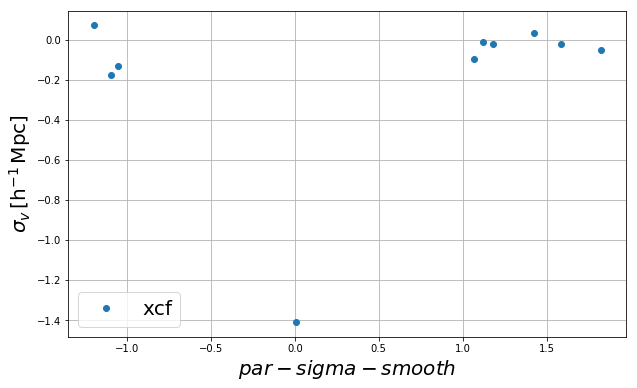

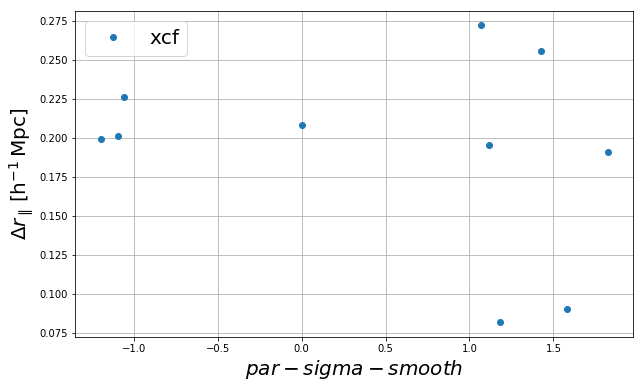

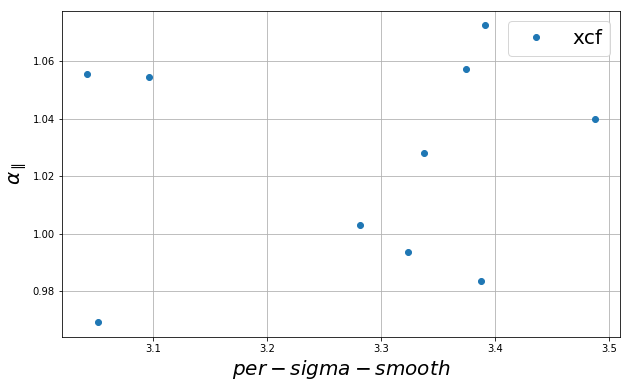

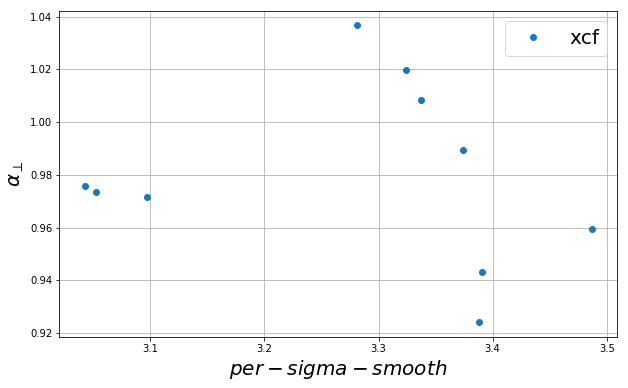

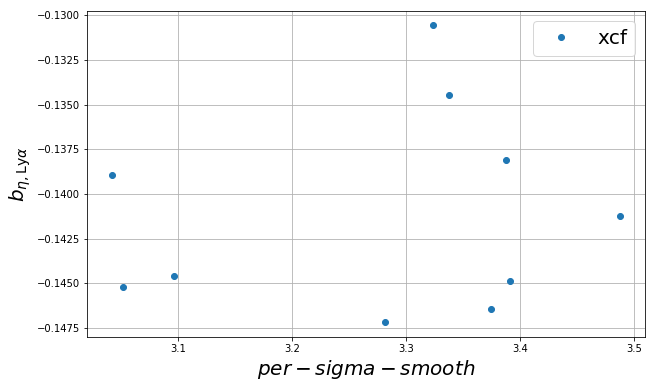

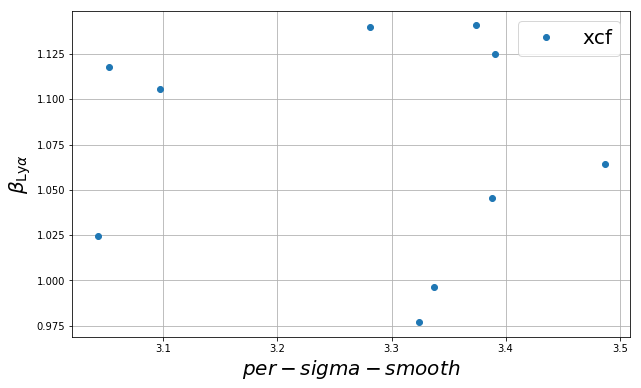

per_sigma_smooth beta_QSO


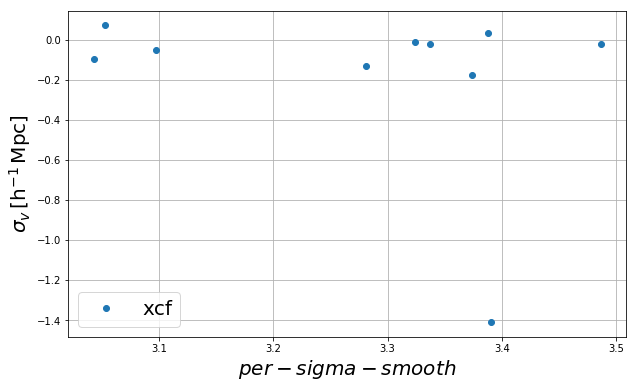

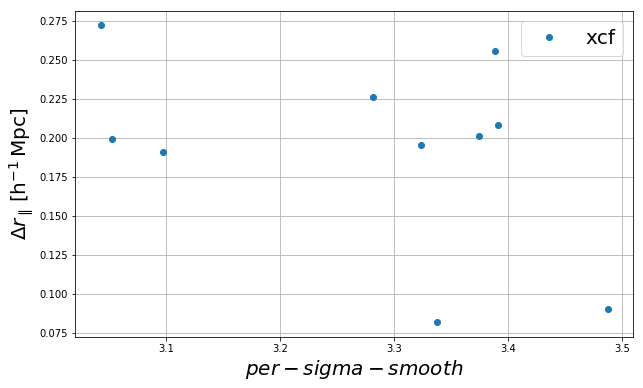

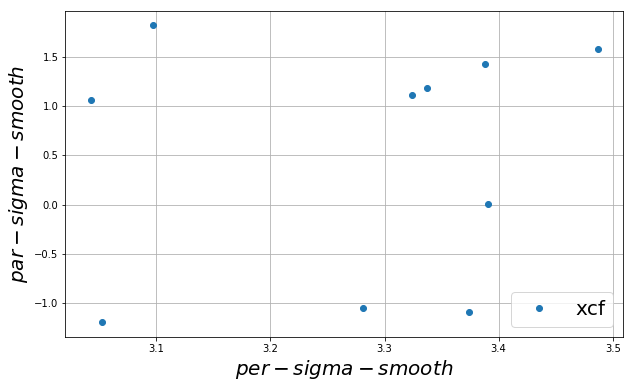

In [21]:
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]

    for cor in ['cf','xcf']:
        for i,p1 in enumerate(list(latexname.keys())):
            yyy = sp.zeros( (mock['nbReal'],2))
            yer = sp.zeros( (mock['nbReal'],2))
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p1 in toPlot[name]['FIT_RES']:
                    yyy[idx,0] = toPlot[name]['FIT_RES'][p1][0]
                    yer[idx,0] = toPlot[name]['FIT_RES'][p1][1]
            for p2 in list(latexname.keys())[:i]:
                if p1==p2: continue
                yyy[:,1] = 0.
                yer[:,1] = 0.
                for idx in range(mock['nbReal']):
                    name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                    if 'FIT_RES' in toPlot[name] and p2 in toPlot[name]['FIT_RES']:
                        yyy[idx,1] = toPlot[name]['FIT_RES'][p2][0]
                        yer[idx,1] = toPlot[name]['FIT_RES'][p2][1]
                w = (yer[:,0]>0.) & (yer[:,1]>0.)
                if w.sum()==0:
                    print(p1,p2)
                    continue
                plt.errorbar(yyy[w,0], yyy[w,1], fmt='o',label=cor)
                plt.xlabel(r'$'+latexname[p1]+'$')
                plt.ylabel(r'$'+latexname[p2]+'$')
                plt.legend()
                plt.grid()
                plt.show()

# __Mean correlation__

In [76]:
#fi = sorted(glob.glob(data['picca']+'/Correlations/Fit/xcf_z_*_noMet/result.h5'))
fi = sorted(glob.glob(mock['picca_all']+'/cf_z*.h5'))
ff = h5py.File(fi[0],'r')
cosmo_pars = ['bias_LYA',"bias_eta_LYA","beta_LYA","bias_eta_QSO","beta_QSO","ap","at"]
all_pars = [p.decode('utf-8') for p in ff['best fit'].attrs['list of free pars']]
bname0 = fi[0].replace(".h5","")
ff.close()

print("{:20}".format(""),end="")
for f in fi:
    print("{:^20}".format(f.replace("-exp.h5","")),end=" ")
print("")

print("{:20}".format("zeff"),end="")
for f in fi:
    ff = h5py.File(f,'r')
    try:
        zeff = ff['best fit'].attrs['zeff']
    except:
        print("PROBLEM: {}".format(f))
        continue
    out = "{}".format(round(zeff,2))
    print("{:^20}".format(out),end="")
    ff.close()
print("")

for par in cosmo_pars:
    print("{:20}".format(par),end="")
    for f in fi:
        ff = h5py.File(f,'r')
        if par in ff['best fit'].attrs:
            p,dp = ff['best fit'].attrs[par]
            out = "{} +/- {}".format(round(p,4), round(dp,4))
            print("{:^20}".format(out),end="")
        ff.close()
    print("")
    
for par in all_pars:
    if par in cosmo_pars:
        continue
    print("{:20}".format(par[:20]),end="")
    for f in fi:
        ff = h5py.File(f,'r')
        bname = f.replace(".h5","")
        pa = par.replace(bname0,bname)
        if pa in ff['best fit'].attrs:
            p,dp = ff['best fit'].attrs[pa]
            out = "{} +/- {}".format(round(p,4), round(dp,4))
            print("{:^20}".format(out),end="")
        ff.close()
    print("")
print("{:20}".format("chi2/(ndata-npar)"),end="")
for f in fi:
    ff = h5py.File(f,'r')
    try:
        chi2 = ff['best fit'].attrs['fval']
    except:
        continue
    ndata = ff['best fit'].attrs['ndata']
    npar = ff['best fit'].attrs['npar']
    out = "{}/({}-{})".format(round(chi2,1),ndata,npar)
    print("{:^20}".format(out),end="")
    ff.close()
print("")
print("{:20}".format("probability"),end="")
for f in fi:
    ff = h5py.File(f,'r')
    try:
        chi2 = ff['best fit'].attrs['fval']
    except:
        continue
    ndata = ff['best fit'].attrs['ndata']
    npar = ff['best fit'].attrs['npar']
    proba = 1.-sp.stats.chi2.cdf(chi2,ndata-npar)
    out = "{}".format(round(proba,2))
    print("{:^20}".format(out),end="")
    ff.close()
print("")

                    /project/projectdirs/desi/mocks/lya_forest/picca/london/v6.0/global/eboss-0.1/stack/cf_z_0_10 
zeff                        2.3         
bias_LYA            
bias_eta_LYA         -0.1507 +/- 0.001  
beta_LYA             1.1276 +/- 0.0127  
bias_eta_QSO        
beta_QSO            
ap                   1.0168 +/- 0.0121  
at                    0.991 +/- 0.0146  
par_sigma_smooth     3.1636 +/- 0.0388  
per_sigma_smooth     3.5605 +/- 0.0611  
chi2/(ndata-npar)     1858.8/(1590-6)   
probability                 0.0         


## __in 2d__

In [101]:
def convert1DTo2D(array1D,nbX,nbY):
    '''
        convert a 1D array to a 2D array
    '''

    array2D = sp.zeros(shape=(nbX,nbY))

    for k in range(array1D.size):
        i = k//nbY
        j = k%nbY

        array2D[i][j] = array1D[k]

    return array2D

In [102]:
ttoPlot = {}
ttoPlot['cf'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])
ttoPlot['xcf'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])

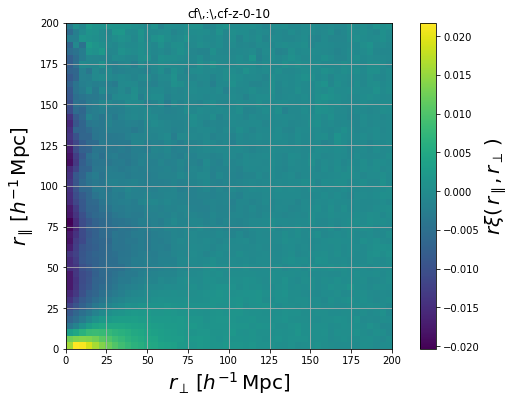

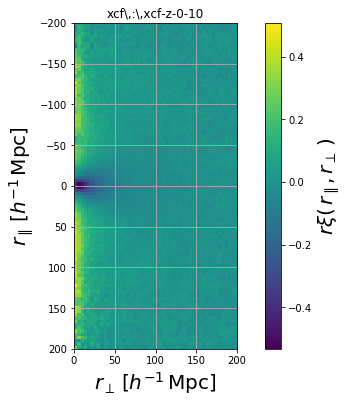

In [103]:
power = 1
for name,paths in sorted(ttoPlot.items()):
    h = fitsio.FITS(paths['CORR'])
    np = h[1].read_header()['NP']
    nt = h[1].read_header()['NT']
    rt_min = 0.
    rt_max = h[1].read_header()['RTMAX']
    rp_min = h[1].read_header()['RPMIN']
    rp_max = h[1].read_header()['RPMAX']
    r = sp.sqrt( h[1]['RP'][:]**2 + h[1]['RT'][:]**2 )
    da = h[1]['DA'][:]
    co = h[1]['CO'][:]
    r = convert1DTo2D(r,np,nt)
    da = convert1DTo2D(da,np,nt)
    er = convert1DTo2D(sp.diag(co),np,nt)
    da[er==0.] = float('nan')
    if name=='cf':
        origin='lower'
        extent = [rt_min, rt_max, rp_min, rp_max]
    elif name=='xcf':
        origin='upper'
        extent=[rt_min, rt_max, rp_max, rp_min]
    plt.imshow(da*r**power, origin=origin,extent=extent, interpolation='nearest')
    cbar = plt.colorbar()
    plt.title(name+'\,:\,'+paths['TITLE'])
    plt.xlabel(r'$r_{\perp} \, [h^{-1} \, \rm{Mpc}]$')
    plt.ylabel(r'$r_{\parallel} \, [h^{-1} \, \rm{Mpc}]$')
    cbar.set_label(r'$r\xi(\, r_{\parallel},r_{\perp} \,)$')
    plt.grid(True)
    cbar.update_ticks()
    plt.show()

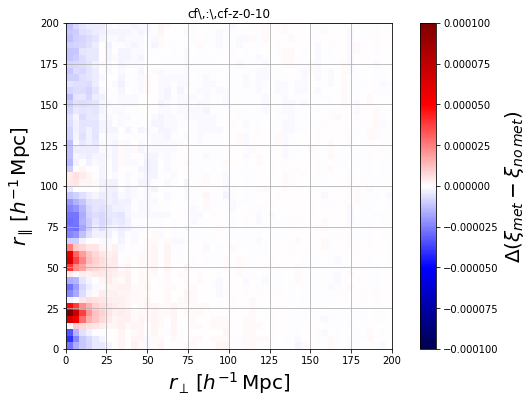

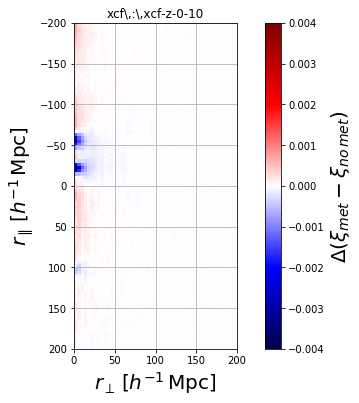

In [104]:
power = 0
for name,paths in sorted(ttoPlot.items()):
    h = fitsio.FITS(paths['CORR'])
    h2 = fitsio.FITS(paths['CORR'].replace('eboss-0.1','eboss-0.0'))
    np = h[1].read_header()['NP']
    nt = h[1].read_header()['NT']
    rt_min = 0.
    rt_max = h[1].read_header()['RTMAX']
    rp_min = h[1].read_header()['RPMIN']
    rp_max = h[1].read_header()['RPMAX']
    r = sp.sqrt( h[1]['RP'][:]**2 + h[1]['RT'][:]**2 )
    da = h[1]['DA'][:]-h2[1]['DA'][:]
    co = h[1]['CO'][:]
    r = convert1DTo2D(r,np,nt)
    da = convert1DTo2D(da,np,nt)
    er = convert1DTo2D(sp.diag(co),np,nt)
    da[er==0.] = float('nan')
    if name=='cf':
        origin='lower'
        extent = [rt_min, rt_max, rp_min, rp_max]
        vminvmax = 0.0001
    elif name=='xcf':
        origin='upper'
        extent=[rt_min, rt_max, rp_max, rp_min]
        vminvmax = 0.004
    plt.imshow(da*r**power, origin=origin,extent=extent,
        interpolation='nearest',cmap='seismic',
        vmin=-vminvmax,vmax=vminvmax)
    cbar = plt.colorbar()
    plt.title(name+'\,:\,'+paths['TITLE'])
    plt.xlabel(r'$r_{\perp} \, [h^{-1} \, \rm{Mpc}]$')
    plt.ylabel(r'$r_{\parallel} \, [h^{-1} \, \rm{Mpc}]$')
    cbar.set_label(r'$\Delta \left( \xi_{met} - \xi_{no\,met} \right)$')
    plt.grid(True)
    cbar.update_ticks()
    plt.show()

## __variance__

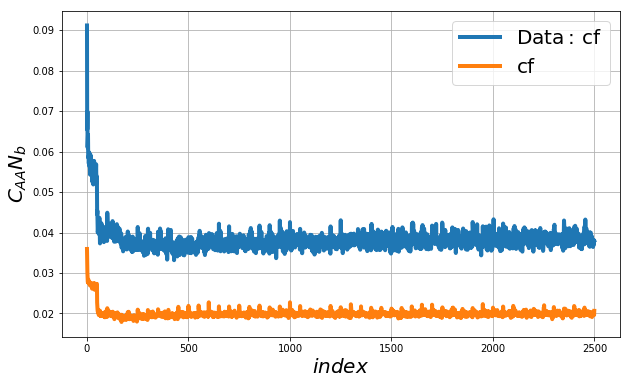

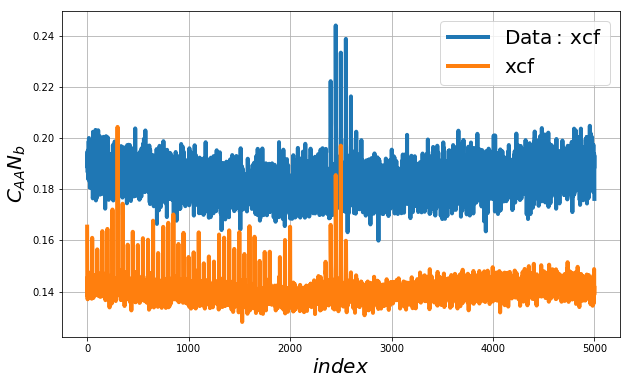

In [105]:
ttoPlot = {}

if data['forest']=='LYA':
    base = 'cf_z_0_10'
    ttoPlot['Data-cf'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'/Correlations/Fit/'+base+'/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    data['picca_n'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16_paper_analysis_new/'
    base = 'cf_LYA_in_LYA_LYA_in_LYB_z_0_10'
    ttoPlot['Data-cf'] = { 'CORR':data['picca_n']+'/Correlations/'+base+'-exp.fits.gz',
                      'FIT':data['picca_n']+'/Correlations/Fit/'+base+'_met/result.h5',
                      'NAME': base}

if data['forest']=='LYA':
    base = 'xcf_z_0_10'
    ttoPlot['Data-xcf'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'_noHCD/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    base = 'xcf_LYA_in_LYB_z_0_10'
    ttoPlot['Data-xcf'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'/result.h5', 'NAME': base}

zmin = 0
zmax = 10
for cor in ['cf','xcf']:

    tpath = ttoPlot['Data-{}'.format(cor)]['CORR']
    h = fitsio.FITS(tpath)
    co = h[1]['CO'][:].copy()
    nb = 1.*h[1]['NB'][:].copy()
    plt.plot(sp.diag(co)*nb,label=r'$\mathrm{Data:\,'+cor+'}$')

    tpath = toPlot['{}-Mock-{}-z-{}-{}'.format('all',cor,zmin,zmax)]['CORR']
    h = fitsio.FITS(tpath)
    co = h[1]['CO'][:].copy()
    nb = 1.*h[1]['NB'][:].copy()
    #plt.plot(sp.diag(co)*nb,label=r'$\mathrm{Stack:\,'+cor+'}$')

    nbCor = 0
    for idx in range(mock['nbReal']):
        tpath = mock['picca'].replace('<*>',str(idx))+'/{}_z_{}_{}-exp.fits'.format(cor,zmin,zmax)
        try:
            h = fitsio.FITS(tpath)
        except:
            continue
        nbCor += 1
        if idx==0:
            co = h[1]['CO'][:].copy()
            nb = 1.*h[1]['NB'][:].copy()
        else:
            co += h[1]['CO'][:]
            nb += h[1]['NB'][:]
        h.close()
    co /= nbCor#mock['nbReal']
    nb /= nbCor#mock['nbReal']

    plt.plot(sp.diag(co)*nb,label=r'$\mathrm{'+cor+'}$')
    
    plt.xlabel(r'$index$')
    plt.ylabel(r'$C_{AA}N_{b}$')
    plt.legend()
    plt.grid()
    plt.show()

In [106]:
ttoPlot = {}
ttoPlot['cf'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])
ttoPlot['xcf'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])

base = 'cf_z_0_10'
ttoPlot['Data-cf'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'/Correlations/Fit/'+base+'/result.h5', 'NAME': base}

base = 'xcf_z_0_10'
ttoPlot['Data-xcf'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'_noHCD/result.h5', 'NAME': base}

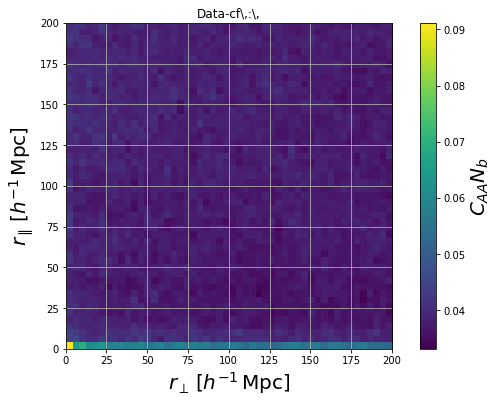

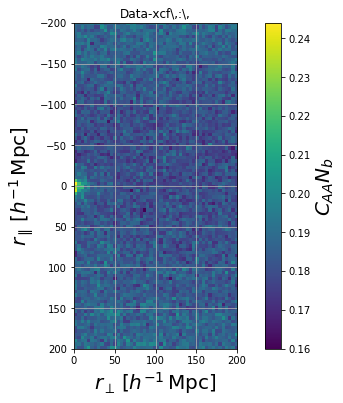

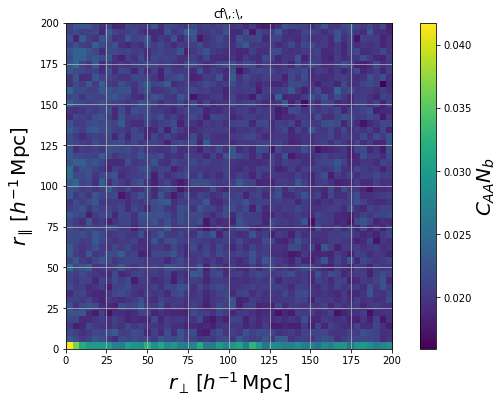

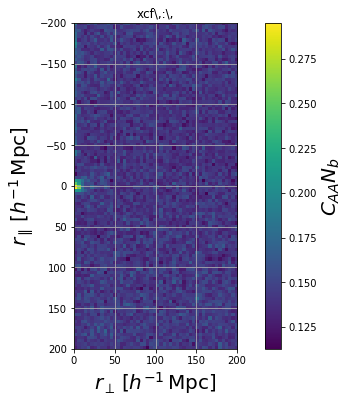

In [107]:
power = 0
for name,paths in sorted(ttoPlot.items()):
    h = fitsio.FITS(paths['CORR'])
    np = h[1].read_header()['NP']
    nt = h[1].read_header()['NT']
    rt_min = 0.
    rt_max = h[1].read_header()['RTMAX']
    rp_min = h[1].read_header()['RPMIN']
    rp_max = h[1].read_header()['RPMAX']
    r = sp.sqrt( h[1]['RP'][:]**2 + h[1]['RT'][:]**2 )
    nb = h[1]['NB'][:]
    da = h[1]['DA'][:]
    co = h[1]['CO'][:]
    r = convert1DTo2D(r,np,nt)
    nb = convert1DTo2D(nb,np,nt)
    er = convert1DTo2D(sp.diag(co),np,nt)
    er[er==0.] = float('nan')
    if 'xcf' in name:
        origin='upper'
        extent=[rt_min, rt_max, rp_max, rp_min]
    elif 'cf' in name:
        origin='lower'
        extent = [rt_min, rt_max, rp_min, rp_max]
    plt.imshow(er*nb*r**power, origin=origin,extent=extent, interpolation='nearest')
    cbar = plt.colorbar()
    plt.title(name+'\,:\,')
    plt.xlabel(r'$r_{\perp} \, [h^{-1} \, \rm{Mpc}]$')
    plt.ylabel(r'$r_{\parallel} \, [h^{-1} \, \rm{Mpc}]$')
    cbar.set_label(r'$C_{AA}N_{b}$')
    plt.grid(True)
    cbar.update_ticks()
    plt.show()

# Wedge plots

In [114]:
ttoPlot = {}
ttoPlot['Std'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])

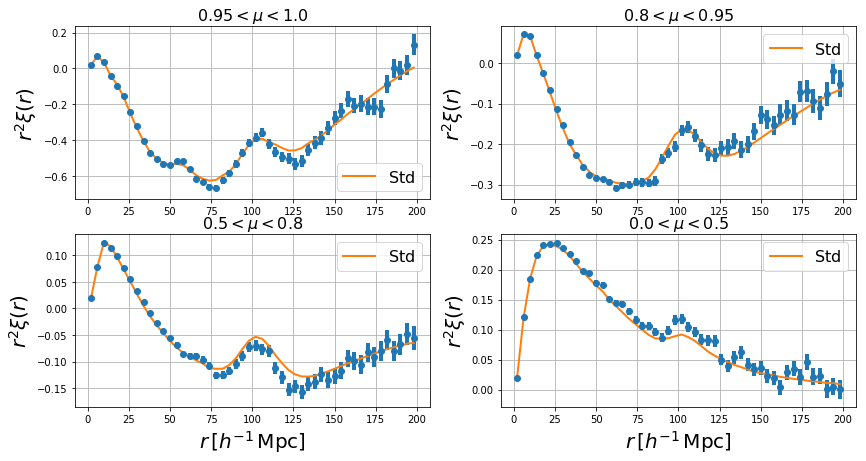

In [115]:
mus = [1., 0.95, 0.8, 0.5, 0.]

f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

for i, (mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
    for j,(name,paths) in enumerate(sorted(ttoPlot.items())):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        axs[i//2][i%2].errorbar(r,d*r**2,yerr=sp.sqrt(c.diagonal())*r**2,fmt="o")
        axs[i//2][i%2].plot(r,f*r**2,linewidth=2,label=r'$\mathrm{'+name+'}$')#,color='red')
    axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
    if i//2==1:
        axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    axs[i//2][i%2].legend(fontsize=16)
    axs[i//2][i%2].grid()
plt.show()

In [136]:
ttoPlot = {}
ttoPlot['Std'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])

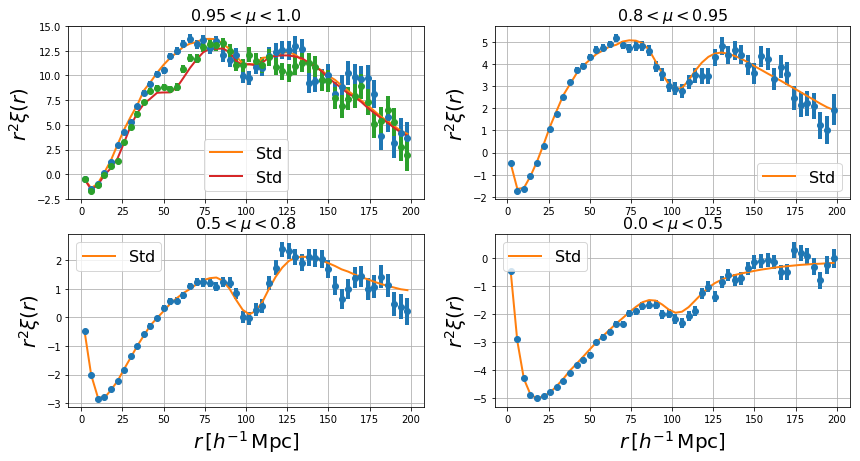

In [138]:
mus = [1., 0.95, 0.8, 0.5, 0.]
power = 2
f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

for i,(mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
    for j,(name,paths) in enumerate(sorted(ttoPlot.items())):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        if mumax==1.:
            b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=False)
            r,d,c = b.wedge(da,co)
            r,f,_ = b.wedge(fit,co)
            if j==0:
                axs[i//2][i%2].errorbar(r,d*r**power,yerr=sp.sqrt(c.diagonal())*r**power,fmt="o")
            axs[i//2][i%2].plot(r,f*r**power,linewidth=2,label=r'$\mathrm{'+name+'}$')#color='red'
            
            b = wedgize.wedge(mumin=-mumax,mumax=-mumin,rpmin=rpmin,nrp=np,absoluteMu=False)
            r,d,c = b.wedge(da,co)
            r,f,_ = b.wedge(fit,co)
            if j==0:
                axs[i//2][i%2].errorbar(r,d*r**power,yerr=sp.sqrt(c.diagonal())*r**power,fmt="o")
            axs[i//2][i%2].plot(r,f*r**power,linewidth=2,label=r'$\mathrm{'+name+'}$')#color='red'
        else:
            b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
            r,d,c = b.wedge(da,co)
            r,f,_ = b.wedge(fit,co)
            if j==0:
                axs[i//2][i%2].errorbar(r,d*r**power,yerr=sp.sqrt(c.diagonal())*r**power,fmt="o")
            axs[i//2][i%2].plot(r,f*r**power,linewidth=2,label=r'$\mathrm{'+name+'}$')#color='red'
    axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
    if i//2==1:
        axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    axs[i//2][i%2].legend(fontsize=16)
    axs[i//2][i%2].grid()
plt.show()

# Slice plots

In [126]:
ttoPlot = {}
ttoPlot['Mock'] = toPlot['all-Mock-cf-z-0-10']

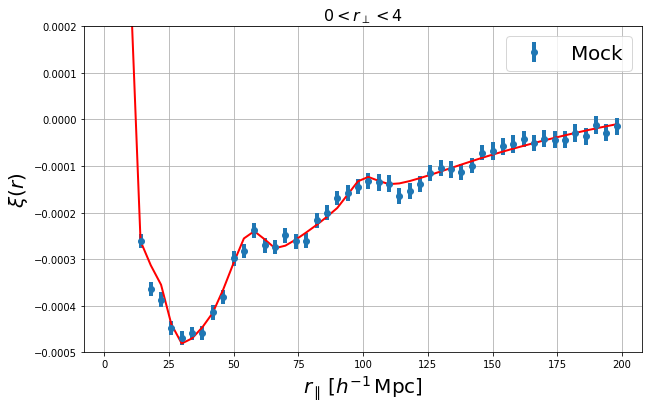

In [130]:
slices = [0]
for s in slices:
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        rp = h[1]['RP'][:]
        rt = h[1]['RT'][:]
        drt = h[1].read_header()['RTMAX'] / h[1].read_header()['NT']
        da = h[1]['DA'][:]
        er = sp.sqrt(sp.diag(h[1]['CO'][:]))
        h.close()
        ff.close()
        w = (rt>=s*drt) & (rt<(s+1)*drt)
        rp = rp[w]
        da = da[w]
        fit = fit[w]
        er = er[w]
        plt.errorbar(rp,da,yerr=er,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(rp,fit,color='red',linewidth=2)
        ff.close()
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r_{\parallel} \, [h^{-1}\, \mathrm{Mpc}]$")
    plt.title(r"${}<r_\perp<{}$".format(int(s*drt),int((s+1)*drt)),fontsize=16)
    plt.ylim([-0.0005,0.0002])
    plt.legend()
    plt.grid()
    plt.show()

In [139]:
ttoPlot = {}
ttoPlot['Mock'] = toPlot['all-Mock-xcf-z-0-10']

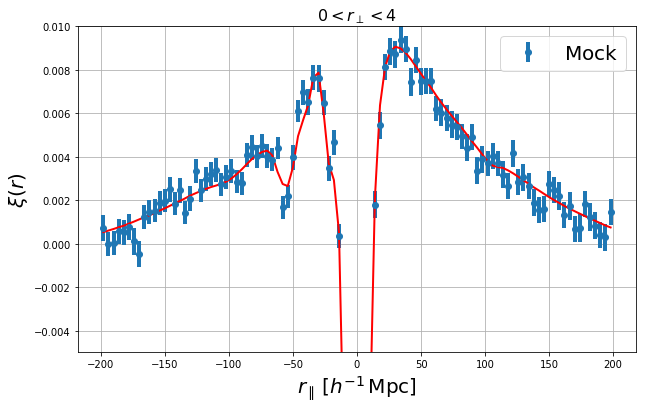

In [140]:
slices = [0]
for s in slices:
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        rp = h[1]['RP'][:]
        rt = h[1]['RT'][:]
        drt = h[1].read_header()['RTMAX'] / h[1].read_header()['NT']
        da = h[1]['DA'][:]
        er = sp.sqrt(sp.diag(h[1]['CO'][:]))
        h.close()
        ff.close()
        w = (rt>=s*drt) & (rt<(s+1)*drt)
        rp = rp[w]
        da = da[w]
        fit = fit[w]
        er = er[w]
        plt.errorbar(rp,da,yerr=er,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(rp,fit,color='red',linewidth=2)
        ff.close()
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r_{\parallel} \, [h^{-1}\, \mathrm{Mpc}]$")
    plt.title(r"${}<r_\perp<{}$".format(int(s*drt),int((s+1)*drt)),fontsize=16)
    plt.ylim([-0.005,0.01])
    plt.legend()
    plt.grid()
    plt.show()

In [124]:
ttoPlot = {}
for idx in range(mock['nbReal']):
    ttoPlot[str(idx)] = copy.deepcopy(toPlot['{}-Mock-{}-z-{}-{}'.format(idx,'cf','0','10')])
ttoPlot['Std'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])

if data['forest']=='LYA':
    base = 'cf_z_0_10'
    ttoPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'/Correlations/Fit/'+base+'/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    data['picca_n'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16_paper_analysis_new/'
    base = 'cf_LYA_in_LYA_LYA_in_LYB_z_0_10'
    ttoPlot['Data'] = { 'CORR':data['picca_n']+'/Correlations/'+base+'-exp.fits.gz',
                      'FIT':data['picca_n']+'/Correlations/Fit/'+base+'_met/result.h5',
                      'NAME': base}

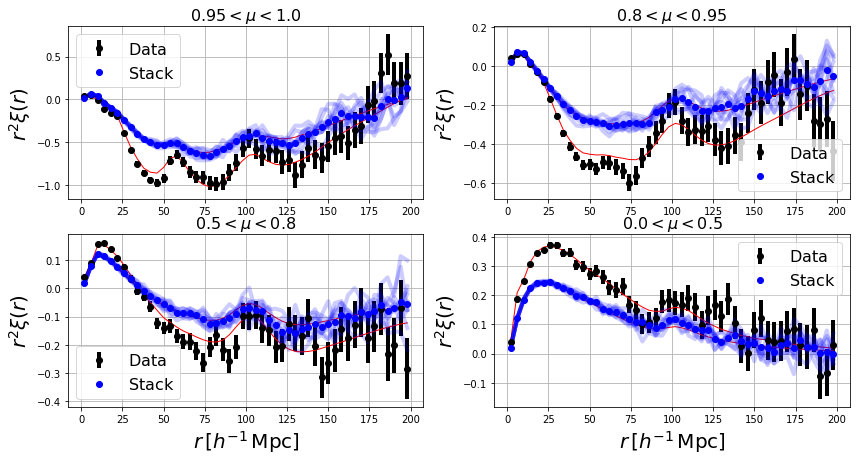

In [72]:
mus = [1., 0.95, 0.8, 0.5, 0.]

f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

for i, (mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        if name=='Std':
            axs[i//2][i%2].errorbar(r,d*r**2,fmt="o",label=r'$\mathrm{Stack}$',color='blue')
            axs[i//2][i%2].plot(r,f*r**2,color='red',linewidth=1)
        elif name=='Data':
            axs[i//2][i%2].errorbar(r,d*r**2,yerr=sp.sqrt(c.diagonal())*r**2,fmt="o",label=r'$\mathrm{Data}$',color='black')
            axs[i//2][i%2].plot(r,f*r**2,color='red',linewidth=1)
        else:
            alpha = 0.2
            axs[i//2][i%2].errorbar(r,d*r**2,color='blue',alpha=alpha)
    axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
    if i//2==1:
        axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    axs[i//2][i%2].legend(fontsize=16)
    axs[i//2][i%2].grid()
plt.show()

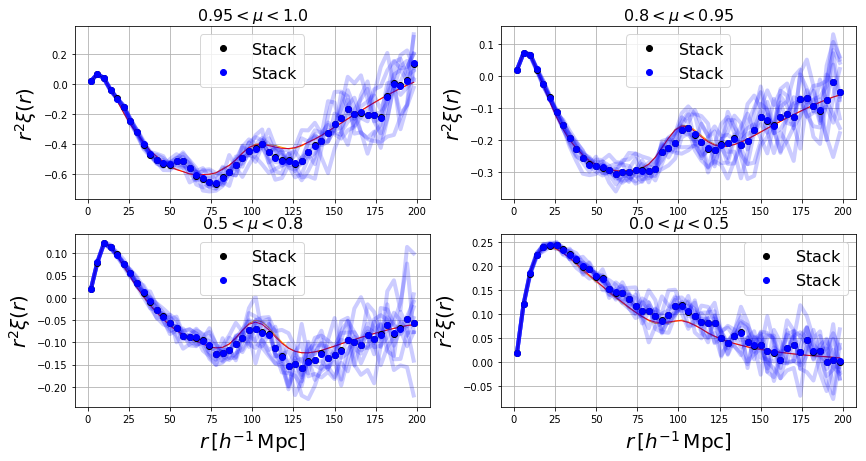

In [37]:
mus = [1., 0.95, 0.8, 0.5, 0.]

f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

for i, (mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
    mean = None
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        if name=='Std':
            axs[i//2][i%2].errorbar(r,d*r**2,fmt="o",label=r'$\mathrm{Stack}$',color='black')
            axs[i//2][i%2].plot(r,f*r**2,color='orange',linewidth=1)
            continue
        elif name=='Data':
            continue
        else:
            if mean is None:
                mean = sp.array([r,d,f])
            else:
                mean += sp.array([r,d,f])
            alpha = 0.2
            axs[i//2][i%2].errorbar(r,d*r**2,color='blue',alpha=alpha)
    mean /= mock['nbReal']
    r = mean[0]
    d = mean[1]
    f = mean[2]
    axs[i//2][i%2].errorbar(r,d*r**2,fmt="o",label=r'$\mathrm{Stack}$',color='blue')
    axs[i//2][i%2].plot(r,f*r**2,color='red',linewidth=1)
            
    axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
    if i//2==1:
        axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    axs[i//2][i%2].legend(fontsize=16)
    axs[i//2][i%2].grid()
plt.show()

In [38]:
ttoPlot = {}
for idx in range(mock['nbReal']):
    ttoPlot[str(idx)] = copy.deepcopy(toPlot['{}-Mock-{}-z-{}-{}'.format(idx,'xcf','0','10')])
ttoPlot['Std'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])

if data['forest']=='LYA':
    base = 'xcf_z_0_10'
    ttoPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'_noHCD/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    base = 'xcf_LYA_in_LYB_z_0_10'
    ttoPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'/result.h5', 'NAME': base}


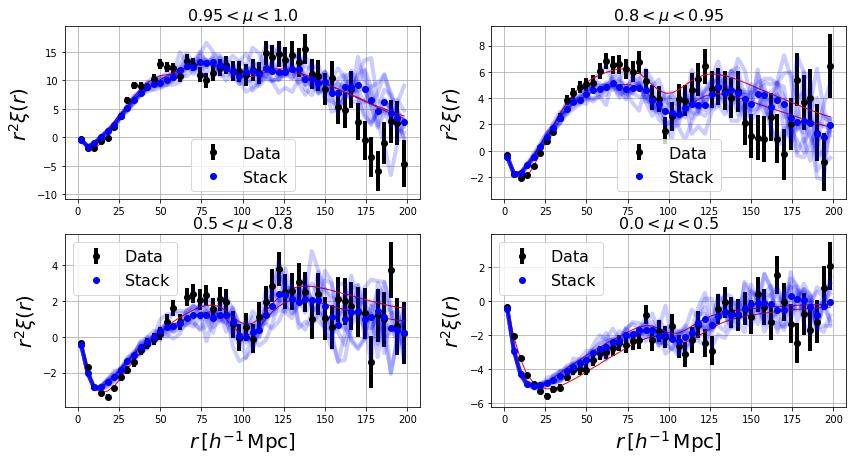

In [39]:
mus = [1., 0.95, 0.8, 0.5, 0.]

f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

for i, (mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        if name=='Std':
            axs[i//2][i%2].errorbar(r,d*r**2,fmt="o",label=r'$\mathrm{Stack}$',color='blue')
            axs[i//2][i%2].plot(r,f*r**2,color='red',linewidth=1)
        elif name=='Data':
            axs[i//2][i%2].errorbar(r,d*r**2,yerr=sp.sqrt(c.diagonal())*r**2,fmt="o",label=r'$\mathrm{Data}$',color='black')
            axs[i//2][i%2].plot(r,f*r**2,color='red',linewidth=1)
        else:
            alpha = 0.2
            axs[i//2][i%2].errorbar(r,d*r**2,color='blue',alpha=alpha)
    axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
    if i//2==1:
        axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    axs[i//2][i%2].legend(fontsize=16)
    axs[i//2][i%2].grid()
plt.show()

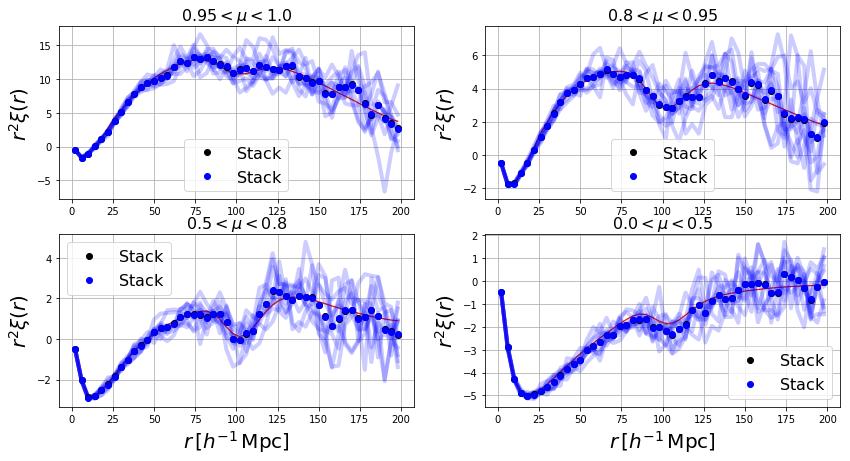

In [40]:
mus = [1., 0.95, 0.8, 0.5, 0.]

f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

for i, (mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
    mean = None
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        if name=='Std':
            axs[i//2][i%2].errorbar(r,d*r**2,fmt="o",label=r'$\mathrm{Stack}$',color='black')
            axs[i//2][i%2].plot(r,f*r**2,color='orange',linewidth=1)
            continue
        elif name=='Data':
            continue
        else:
            if mean is None:
                mean = sp.array([r,d,f])
            else:
                mean += sp.array([r,d,f])
            alpha = 0.2
            axs[i//2][i%2].errorbar(r,d*r**2,color='blue',alpha=alpha)
    mean /= mock['nbReal']
    r = mean[0]
    d = mean[1]
    f = mean[2]
    axs[i//2][i%2].errorbar(r,d*r**2,fmt="o",label=r'$\mathrm{Stack}$',color='blue')
    axs[i//2][i%2].plot(r,f*r**2,color='red',linewidth=1)
            
    axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
    if i//2==1:
        axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    axs[i//2][i%2].legend(fontsize=16)
    axs[i//2][i%2].grid()
plt.show()

## __bias of QSO__

In [41]:
def alpha(z,a0,a1,zeff=2.30):
    evol = a0*((1.+z)/(1.+zeff))**a1
    return evol
def bias_vs_z_std(z, zref, alpha):
    r = ((1.+z)/(1+zref))**alpha
    return r
def growthRateStructure(z, omega_M_0=0.315):
    omega_m = omega_M_0*(1.+z)**3 / ( omega_M_0*(1.+z)**3+(1.-omega_M_0))
    f = sp.power(omega_m,0.55)
    return f

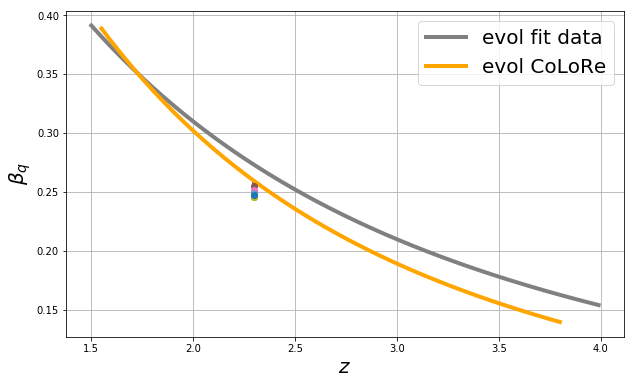

In [42]:
omega_M_0 = 0.315
z = sp.arange(1.5,4.,0.01)
f = growthRateStructure(z, omega_M_0)
bias = bias_vs_z_std(z, zref=0.37, alpha=1.44)
beta = f/bias
plt.plot(z,beta,linewidth=4,label='evol fit data',color='grey')

biasCoLoRe = sp.loadtxt(os.path.expandvars(mock['input_bias_QSO_evol']))
betaCoLoRe = growthRateStructure(biasCoLoRe[:,0], omega_M_0)/biasCoLoRe[:,1]
w = biasCoLoRe[:,0]>1.5
plt.plot(biasCoLoRe[:,0][w],betaCoLoRe[w],linewidth=4,label='evol CoLoRe',color='orange')

for name,vals in toPlot.items():
    if not 'FIT_RES' in vals.keys(): continue
    lst = [ vals['FIT_RES'] ]
    xxx = sp.array([ el['ZEFF'] for el in lst if ('beta_QSO' in el.keys())])
    yyy = sp.array([ el['beta_QSO'][0] for el in lst if ('beta_QSO' in el.keys()) ])
    zzz = sp.array([ el['beta_QSO'][1] for el in lst if ('beta_QSO' in el.keys()) ])
    w = zzz>0.
    if w.sum()==0: continue
    plt.errorbar(xxx[w],yyy[w],zzz[w],fmt='o')

### (Mock) Fit the evolution
cor = [vals['FIT_RES'] for name,vals in toPlot.items() if (not 'Data' in name)
       and (not '0-10' in name) and ('FIT_RES' in vals.keys())]
xxx = sp.array([ el['ZEFF'] for el in cor if ('beta_QSO' in el.keys()) ])
yyy = sp.array([ el['beta_QSO'][0] for el in cor if ('beta_QSO' in el.keys()) ])
err = sp.array([ el['beta_QSO'][1] for el in cor if ('beta_QSO' in el.keys()) ])
#plt.errorbar(xxx,yyy,err,fmt='o',color='black',label='Mock')

### (Data) Fit the evolution
#cor = [vals['FIT_RES'] for name,vals in toPlot.items() if (not 'Mock' in name) and (not '0-10' in name) and ('FIT_RES' in vals.keys()) ]
#xxx = sp.array([ el['ZEFF'] for el in cor if ('beta_QSO' in el.keys()) ])
#yyy = sp.array([ el['beta_QSO'][0] for el in cor if ('beta_QSO' in el.keys()) ])
#err = sp.array([ el['beta_QSO'][1] for el in cor if ('beta_QSO' in el.keys()) ])
#plt.errorbar(xxx,yyy,err,fmt='o',color='green',label='Data')

plt.xlabel(r'$z$')
plt.ylabel(r'$\beta_{q}$')
plt.legend()
#plt.xlim([2.3,2.32])
#plt.ylim([0.24,0.27])
plt.grid()
plt.show()

# __evolution of betaQSO with rmin__ 

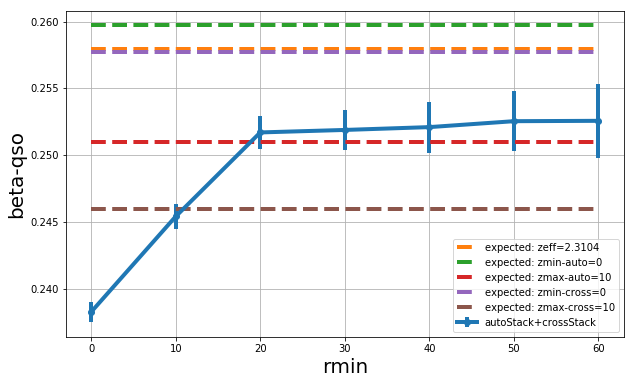

In [43]:
raw = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v6.0/global/eboss-0.0/stack/study_evolution_betaQSO_with_rmin/'
lst = {}
lst[0] = raw+'/cfxcf_z_0_10-exp_rmin00.h5'
lst[10] = raw+'/cfxcf_z_0_10-exp_rmin10.h5'
lst[20] = raw+'/cfxcf_z_0_10-exp_rmin20.h5'
lst[30] = raw+'/cfxcf_z_0_10-exp_rmin30.h5'
lst[40] = raw+'/cfxcf_z_0_10-exp_rmin40.h5'
lst[50] = raw+'/cfxcf_z_0_10-exp_rmin50.h5'
lst[60] = raw+'/cfxcf_z_0_10-exp_rmin60.h5'

h = fitsio.FITS('/project/projectdirs/desi/mocks/lya_forest/picca/london/v6.0/global/eboss-0.0/stack/cf_z_0_10-exp.fits')
zmincf = h[1]['Z'][:].min()
zmaxcf = h[1]['Z'][:].max()
h.close()
h = fitsio.FITS('/project/projectdirs/desi/mocks/lya_forest/picca/london/v6.0/global/eboss-0.0/stack/xcf_z_0_10-exp.fits')
zminxcf = h[1]['Z'][:].min()
zmaxxcf = h[1]['Z'][:].max()
h.close()

xxx = []
yyy = []
yer = []
yexpzeff = []
yexp = []
for rmin,el in lst.items():
    ff = h5py.File(el,'r')
    yexpzeff += [ff['best fit'].attrs['zeff']]
    yexp += [fromztobiasQso(ff['best fit'].attrs['zeff'])]
    p,dp = ff['best fit'].attrs['beta_QSO']
    xxx += [rmin]
    yyy += [p]
    yer += [dp]
    ff.close()
xxx = sp.array(xxx)
yyy = sp.array(yyy)
yer = sp.array(yer)
yexpzeff = sp.array(yexpzeff)
yexp = sp.array(yexp)

plt.errorbar(xxx,yyy,yerr=yer,marker='o',label='autoStack+crossStack')
plt.plot(xxx,yexp,'--',label='expected: zeff={}'.format(round(yexpzeff[0],4)))
plt.plot(xxx,sp.ones(xxx.size)*fromztobiasQso(zmincf),'--',label='expected: zmin-auto={}'.format(round(zmin,4)))
plt.plot(xxx,sp.ones(xxx.size)*fromztobiasQso(zmaxcf),'--',label='expected: zmax-auto={}'.format(round(zmax,4)))
plt.plot(xxx,sp.ones(xxx.size)*fromztobiasQso(zminxcf),'--',label='expected: zmin-cross={}'.format(round(zmin,4)))
plt.plot(xxx,sp.ones(xxx.size)*fromztobiasQso(zmaxxcf),'--',label='expected: zmax-cross={}'.format(round(zmax,4)))
plt.xlabel('rmin')
plt.ylabel('beta-qso')
plt.legend(fontsize=10)
plt.grid()
plt.show()